<a href="https://colab.research.google.com/github/zizilnam/Mini_Project_Machine_Learning_Elo_Merchant_Kaggle/blob/main/Final_sub1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elo Merchant Category Recommendation

# Project 개요

이번 프로젝트의 목표는 고객 충성도를 알아내서 가장 연관성 높은 기회를 개인에게 제공하는 것입니다!

Elo는 브라질에서 가장 큰 결제 서비스 회사입니다.
그들은 사용자들의 신용 카드 정보 및 레스토랑의 정보를 이용해 식당 추천 서비스를 제공합니다.
그리고 이 사용자들에게 할인 및 각종 혜택 제공하기 위해 추천시스템을 이용해 다양한 브랜드들과 파트너쉽을 맺고 있습니다.

이 할인 혜택들은 사용자들에게 상당히 유용한 정보입니다. 그래서 우리는 사용자들이 실제로 이 혜택을 이용할 것인지 분석해야합니다. 사용자가 혜택을 실제로 이용했는가에 대한 정보는 Loyalty score로 표현되어 있습니다.

Loyalty Score는 우리에게 사용자들이 그들에게 주어진 혜택을 얼마나 이용하는지 알려줍니다. 이 data로 Elo는 어떤 사용자들이 더 충성도가 높은지(Loyal한지) 구분하게 됩니다. 만약 Loyal score를 알고 있으면 이들에게 마케팅을 집중하면 되기 때문에 마케팅 비용이 획기적으로 줄게 됩니다. 결과적으로 Elo 입장에서도 사용자 입장에서도 더 만족도 높은 경험을 갖게 됩니다.

이번 프로젝트는 다음의 과정을 따를 계획입니다.
EDA --> Feature Engineering --> Model(Binary Classification(High prob of outlier + Low Prob of outlier) + Full Regression) --> Submission



# EDA

https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo

이번 프로젝트의 목표는 고객 충성도를 알아내서 가장 연관성 높은 기회를 개인에게 제공하는 것입니다!
그러므로 우리가 구하려고 하는 loyal_score와 우리에게 주어진 feature들이 어떤 관계를 가지고 있는지 알아보는 EDA를 진행할 것입니다.

EDA 작업을 보면 우리에게 직접적으로 주어진 데이터들은 loyal_score를 그렇게 직접적으로 설명하지 않습니다. 그러므로 필수적으로 feature engineering을 해야할 것으로 보입니다.

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

import datetime as dt
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment =None
pd.options.display.max_columns = 999

## Dataset Exploration
일단 어떤 파일들이 있는지 알아봅시다~ 이따가 열어보면 알게 되지만 데이터들이 서로 중첩되어 있기 때문에 후에 병합하는 과정이 필요할 수 있습니다.

- train.csv - 트레이닝 세트
- test.csv - 테스트 세트
- sample_submission.csv - 옳은 포맷의 샘플 제출 파일(우리가 예측해야할 cards_ids가 포함 되어있다.)
- historical_transactions.csv - 3달치의 card_ids 별 거래 기록
- merchants.csv - 상인들의 merchant_ids 별 모든 추가적인 정보
- new_merchant_transactions.csv - 모든 card_ids의 historical_transactions에서 방문하지 않은 모든 구입들의 두달치 데이터


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/train.csv", parse_dates=["first_active_month"])
test_df = pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/test.csv", parse_dates=["first_active_month"])
print("Number of rows and columns in train set : ", train_df.shape)
print("Number of rows and columns in test set : ", test_df.shape)

Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)


In [ ]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


Target Column Exploration

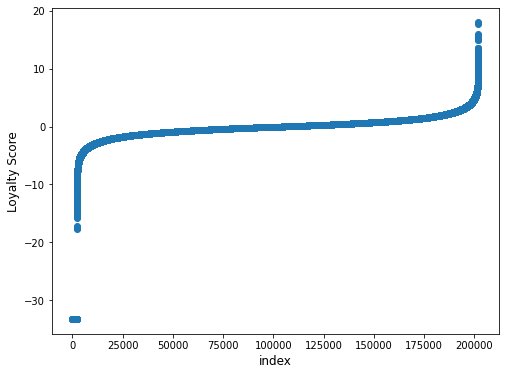

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df["target"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel("Loyalty Score", fontsize=12)
plt.show()

<Figure size 864x1152 with 0 Axes>

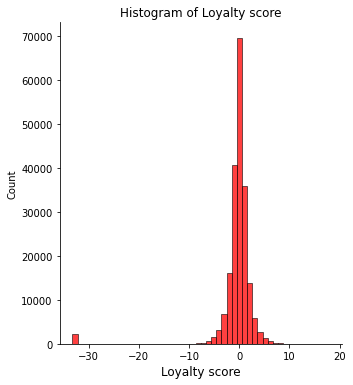

In [ ]:
plt.figure(figsize=(12,16))
sns.displot(train_df["target"].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel("Loyalty score", fontsize=12)
plt.show()

위의 그래프를 보면 -30 밑의 Loyalty score에 다른 데이터에 비해서 거리가 있는 데이터가 보입니다. 숫자를 세어볼까용?

In [ ]:
(train_df["target"]<-30).sum()

2207

2207개의 행이 나머지와 다른 성질을 보입니다. 그러므로 RMSE 평가시에 이 행들이 중요한 역할을 할 겁니다. 그러므로 후에 모델시에 이 아웃라이어를 어떻게 다룰지가  학습 과정에서 굉장히 중요할 겁니다.

## First Active Month
테스트 세트와 트레인 세트의 카드별 First active month 데이터에서 분산 차이가 있는지 확인해봅시다. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



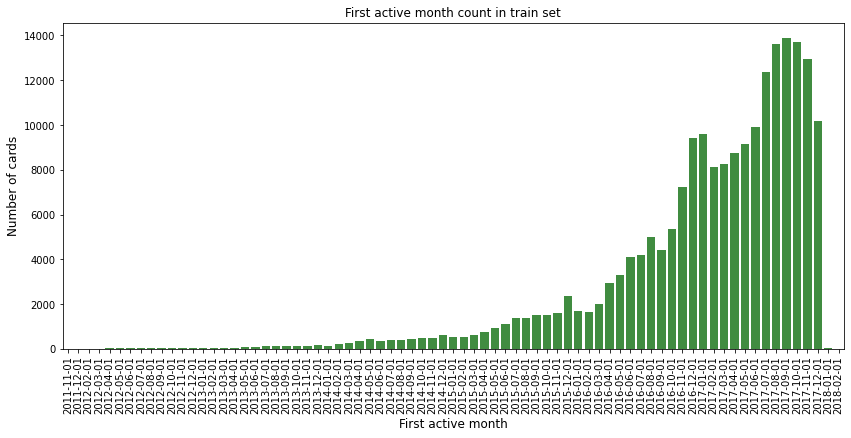

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



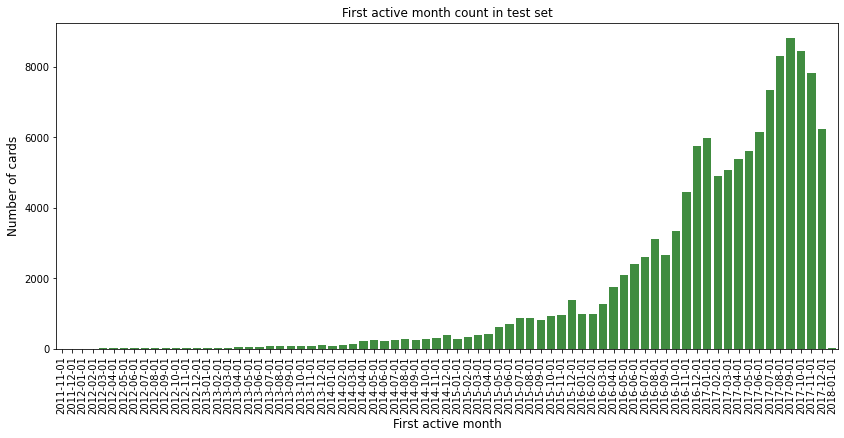

In [ ]:
cnt_srs = train_df["first_active_month"].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title('First active month count in train set')
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title('First active month count in test set')
plt.show()

트레인과 테스트 셋의 그래프의 분포가 상당히 비슷한 걸 알 수 있습니다! 그러므로 시간에 기반한 데이터 분할은 필요 없어보입니다.

## Feature 1,2 & 3


트레인 데이터 셋에 있는 다른 변수들이 loyalty score를 찾을 때 좋은 예측력을 갖고 있는지 봅시다

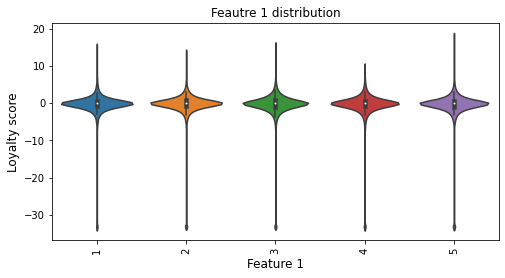

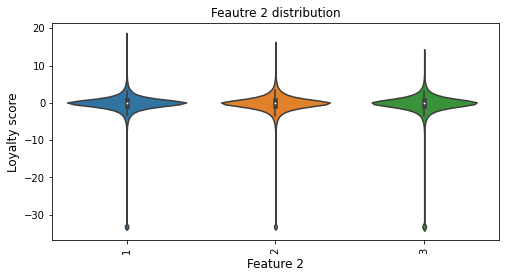

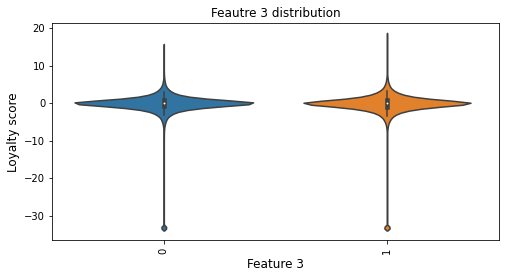

In [ ]:
#feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y="target", data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feautre 1 distribution")
plt.show()

#feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y="target", data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feautre 2 distribution")
plt.show()

#feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y="target", data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feautre 3 distribution")
plt.show()

언뜻 보기에 카테고리별 분산이 다 비슷해 보입니다. 피쳐 엔지니어링 이후 아마도 모델링 결과들로 무언가 알아낼 수 있을 것 같습니다.


## Historical Transactions
Historical transactions 데이터를 봅시다.

In [ ]:
hist_df = pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/historical_transactions.csv")
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


- card_id - 카드 식별
- month_lag - 참고 날짜에서 월 지연 
- purchase_date - 구입 날짜
- authorized_flag - 승인 여부
- category_3 - 모름
- installments - 할부 개월 수
- category_1 - 모름
- merchant_category_id - 판매자 카테고리 id
- subsector_id - 판매자 카테고리 그룹 id
- merchant_id - 판맨자 id
- purchase_amount - normalize 된 판매량
- city_id - 도시 식별
- state_id - 주 식별
- category_2 - 모름

historical transactions의 feature와 트레인 데이터셋, 테스트데이터셋을 합쳐봅시다.

### Number of Historical Transactions for the card

In [ ]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

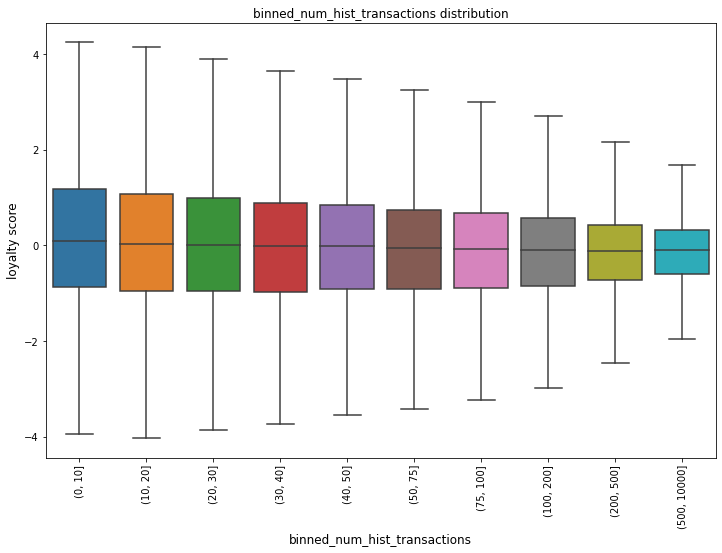

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 200, 500, 10000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_hist_transactions")["target"].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y= "target", data=train_df, showfliers = False)
plt.xticks(rotation='vertical')
plt.xlabel("binned_num_hist_transactions", fontsize=12)
plt.ylabel("loyalty score", fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.show()

## Value of HIstorical Transactions
Now let us check the value of the historical transactions for the cards and check the loyalty score distribution based on that.

In [ ]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns =["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [ ]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions,binned_num_hist_transactions,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,0.212139,-0.739395,2.258395
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,0.384967,-0.742400,4.630299
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,"(40, 50]",-29.167391,-0.678311,0.087380,-0.730138,-0.145847
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,"(75, 100]",-49.491364,-0.642745,0.261624,-0.740897,1.445596
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,"(100, 200]",-48.687656,-0.366073,1.352094,-0.746156,7.193041


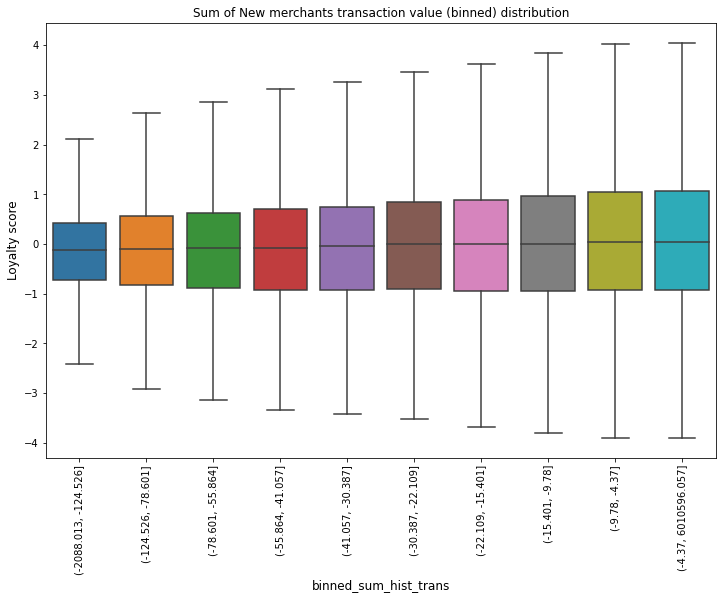

In [ ]:
bins= np.nanpercentile(train_df["sum_hist_trans"], range(0,101,10))
train_df["binned_sum_hist_trans"] = pd.cut(train_df["sum_hist_trans"], bins)
# cnt_srs = train_df.groupby("binned_sum_merch_trans")["target"].eman()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_hist_trans", y="target", data=train_df, showfliers=False)
plt.xticks(rotation="vertical")
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (binned) distribution")
plt.show()

Loyal score은 new merchant transaction value의 총합이 증가하면 같이 증가하면 같이 증가하는 걸로 보입니다. 마지막 bin만 뺴고

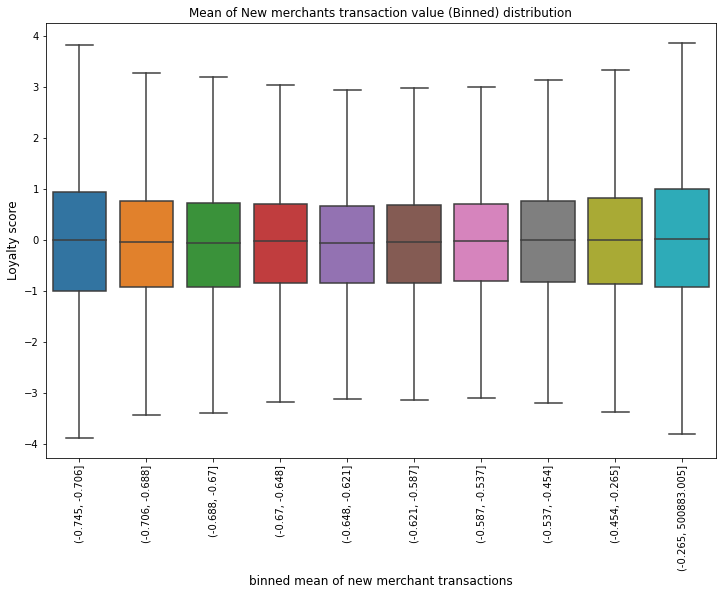

In [ ]:
bins = np.nanpercentile(train_df["mean_hist_trans"], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_hist_trans", y="target", data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of New merchants transaction value (Binned) distribution")
plt.show()

## New Merchant Transactions
new merchant transactions 데이터 분석

In [ ]:
new_trans_df = pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/new_merchant_transactions.csv")
new_trans_df

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963026,Y,C_ID_1320dee851,142,N,0,A,309,M_ID_7754b67f3b,2,-0.701828,2018-04-06 14:36:52,3.0,19,21
1963027,Y,C_ID_f112aa3381,158,N,0,A,560,M_ID_da063195b7,2,-0.694390,2018-03-07 13:19:18,1.0,15,34
1963028,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37
1963029,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16


In [ ]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_merch_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

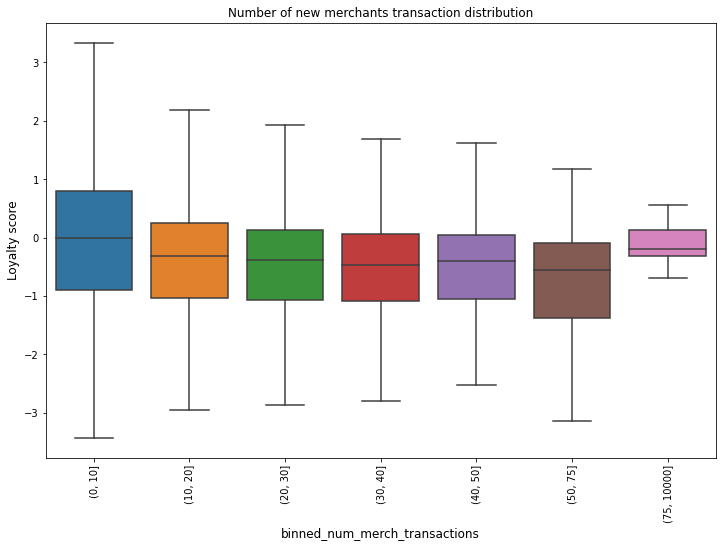

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'], bins)
#cnt_srs = train_df.groupby("binned_num_merch_transactions")["target"].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_merch_transactions", y="target", data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Number of new merchants transaction distribution')
plt.show()

Loyalty score은 마지막 것을 제외하고는 new merchant transactions가 증가할수록 감소합니다.

In [ ]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [ ]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions,binned_num_hist_transactions,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans,binned_sum_hist_trans,binned_mean_hist_trans,num_merch_transactions,binned_num_merch_transactions,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,0.212139,-0.739395,2.258395,"(-2088.013, -124.526]","(-0.648, -0.621]",23.0,"(20, 30]",-13.244202,-0.575835,0.135812,-0.724368,-0.296112
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,0.384967,-0.742400,4.630299,"(-2088.013, -124.526]","(-0.621, -0.587]",6.0,"(0, 10]",-4.355735,-0.725956,0.014326,-0.739410,-0.701858
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,"(40, 50]",-29.167391,-0.678311,0.087380,-0.730138,-0.145847,"(-30.387, -22.109]","(-0.688, -0.67]",1.0,"(0, 10]",-0.700326,-0.700326,NaN,-0.700326,-0.700326
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,"(75, 100]",-49.491364,-0.642745,0.261624,-0.740897,1.445596,"(-55.864, -41.057]","(-0.648, -0.621]",7.0,"(0, 10]",-4.654372,-0.664910,0.065882,-0.734135,-0.566740
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,"(100, 200]",-48.687656,-0.366073,1.352094,-0.746156,7.193041,"(-55.864, -41.057]","(-0.454, -0.265]",36.0,"(30, 40]",-19.926237,-0.553507,0.223821,-0.739395,0.450886


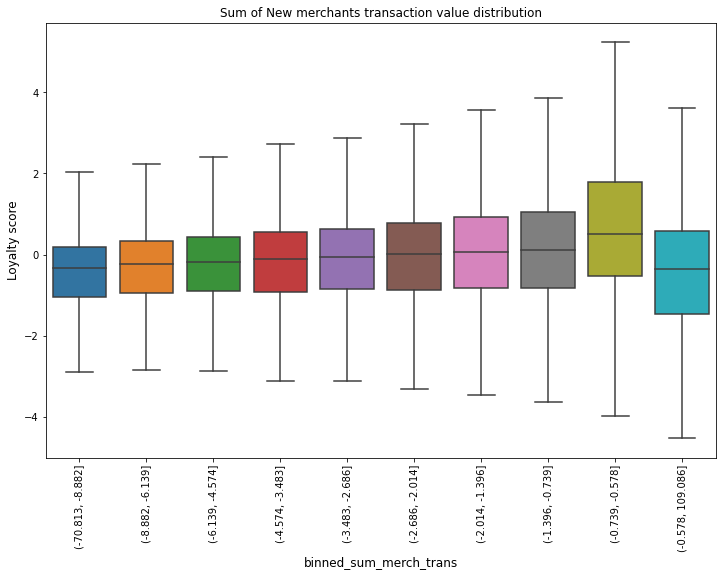

In [ ]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df["binned_sum_merch_trans"] = pd.cut(train_df['sum_merch_trans'], bins)
# cnt_srs = train_df.groupby("binned_sum_merch_trans")["target"].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y="target", data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_merch_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value distribution")
plt.show()

Loyalty score은 마지막 bin을 제외하면 new merchant transactions의 value가 증가하면 함께증가하는 것을 알 수 있습니다.

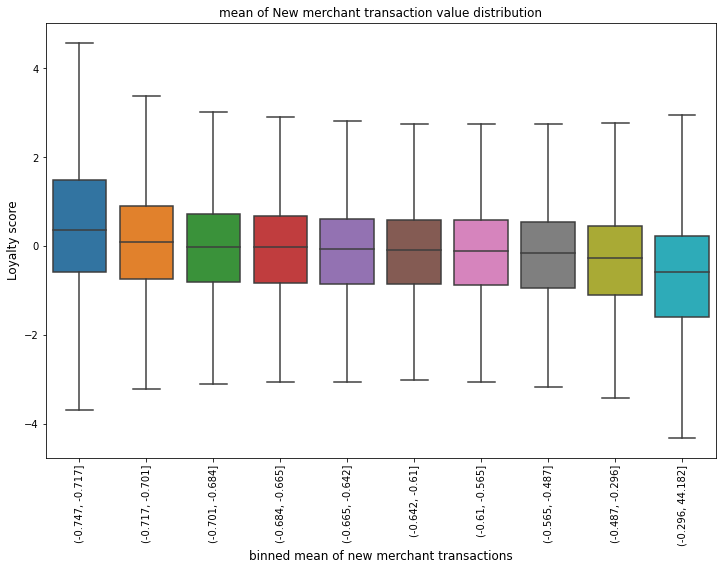

In [ ]:
bins = np.nanpercentile(train_df["mean_merch_trans"], range(0, 101, 10))
train_df["binned_mean_merch_trans"] = pd.cut(train_df['mean_merch_trans'], bins)

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_merch_trans", y="target", data=train_df, showfliers= False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("mean of New merchant transaction value distribution")
plt.show()

## Baseline Model
지금까지 만든 피쳐들로 baseline 모델을 만들어 봅시다. 우리에게 주어진 데이터들과 달리 feature_engineering으로 만든 feature들은 모델과 큰 상관관계가 있는지도 알아봅니다.

In [ ]:
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month", "num_hist_transactions", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]



In [ ]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
  params = {
      "objective" : "regression",
      "metric" : "rmse",
      "num_leaves" :30,
      "min_child_weight" : 50,
      "learning_rate" : 0.05,
      "bagging_fraction" : 0.7,
      "feature_fraction" :0.7,
      "bagging_frequency" : 5,
      "baggin_seed" : 2018,
      "verbosity" : -1
  }

  lgtrain = lgb.Dataset(train_X, label=train_y)
  lgval = lgb.Dataset(val_X, label=val_y)
  evals_result = {}
  model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
  pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
  return pred_test_y, model, evals_result

train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df["target"].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
  dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
  dev_y, val_y = train_y[dev_index], train_y[val_index]

  pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
  pred_test += pred_test_tmp
pred_test /=5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.81049
[200]	valid_0's rmse: 3.80984
Early stopping, best iteration is:
[163]	valid_0's rmse: 3.80946
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.75935
[200]	valid_0's rmse: 3.75958
Early stopping, best iteration is:
[151]	valid_0's rmse: 3.75848
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.80311
[200]	valid_0's rmse: 3.80228
[300]	valid_0's rmse: 3.80269
Early stopping, best iteration is:
[210]	valid_0's rmse: 3.80206
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.7929
[200]	valid_0's rmse: 3.79349
Early stopping, best iteration is:
[145]	valid_0's rmse: 3.79269
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.8547
[200]	valid_0's rmse: 3.85516
Early stopping, best iteration is:
[127]	valid_0's rmse: 3.85456


In [ ]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions,binned_num_hist_transactions,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans,binned_sum_hist_trans,binned_mean_hist_trans,num_merch_transactions,binned_num_merch_transactions,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans,binned_sum_merch_trans,binned_mean_merch_trans,year,month
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,0.212139,-0.739395,2.258395,"(-2088.013, -124.526]","(-0.648, -0.621]",23.0,"(20, 30]",-13.244202,-0.575835,0.135812,-0.724368,-0.296112,"(-70.813, -8.882]","(-0.61, -0.565]",2017,6
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,0.384967,-0.742400,4.630299,"(-2088.013, -124.526]","(-0.621, -0.587]",6.0,"(0, 10]",-4.355735,-0.725956,0.014326,-0.739410,-0.701858,"(-4.574, -3.483]","(-0.747, -0.717]",2017,1
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,"(40, 50]",-29.167391,-0.678311,0.087380,-0.730138,-0.145847,"(-30.387, -22.109]","(-0.688, -0.67]",1.0,"(0, 10]",-0.700326,-0.700326,NaN,-0.700326,-0.700326,"(-0.739, -0.578]","(-0.701, -0.684]",2016,8
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,"(75, 100]",-49.491364,-0.642745,0.261624,-0.740897,1.445596,"(-55.864, -41.057]","(-0.648, -0.621]",7.0,"(0, 10]",-4.654372,-0.664910,0.065882,-0.734135,-0.566740,"(-6.139, -4.574]","(-0.665, -0.642]",2017,9
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,"(100, 200]",-48.687656,-0.366073,1.352094,-0.746156,7.193041,"(-55.864, -41.057]","(-0.454, -0.265]",36.0,"(30, 40]",-19.926237,-0.553507,0.223821,-0.739395,0.450886,"(-70.813, -8.882]","(-0.565, -0.487]",2017,11


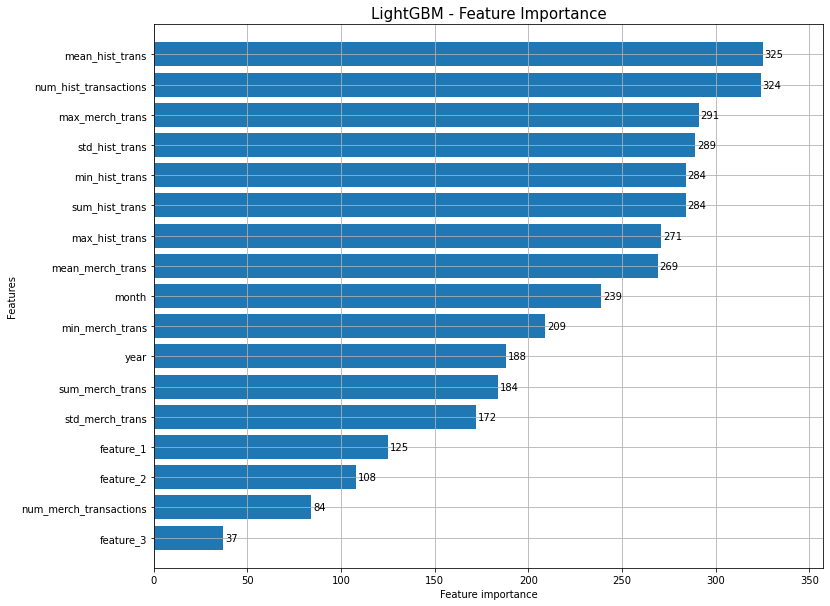

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(True)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

과거에 있었던 거래들의 횟수나 평균값 등이 상대적으로 피쳐 중요도가 높습니다. 그리고 train데이터에 있던 feature 데이터들은 상대적으로 중요도가 낮습니다. 

# Feature Engineering

우리가 주어진 데이터들을 datetime, categorical, numeric 이런 식으로 나눌 수 있습니다. 이 데이터들을 이용해 mean, sum, std, min, max 등의 데이터들을 파생시킬 수 있습니다. 그리고 파생시킨 데이터들을 또 재가공하여 유의미한 데이터를 만들어 낼 수 있습니다.

https://github.com/Rjt5412/Elo-Merchant-Category-Recommendation

In [ ]:
cd/content/drive/MyDrive/KDT/모델링 프로젝트/data

/content/drive/MyDrive/KDT/모델링 프로젝트/data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


대용량 데이터로 인한 메모리가 터지는 사태를 막기위해 업로드하는 데이터를 줄여주는 코드를 작성합니다.

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

import gc
import warnings

## Train file

In [ ]:
train = pd.read_csv("train.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   first_active_month  201917 non-null  object 
 1   card_id             201917 non-null  object 
 2   feature_1           201917 non-null  int64  
 3   feature_2           201917 non-null  int64  
 4   feature_3           201917 non-null  int64  
 5   target              201917 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


 One hot encoding categorical variables

In [ ]:
train = pd.get_dummies(train, columns=['feature_1', 'feature_2', 'feature_3'])

 Converting active month into month difference from now

 Numerical data로 활용하기 위해 현재 날짜에서 빼줍니다.

In [ ]:
train['first_active_month'] = pd.to_datetime(train['first_active_month'], format='%Y-%M')
today = pd.to_datetime('today')
train['first_active_month_diff_from_today'] = (12 * (today.year - train['first_active_month'].dt.year) + (today.month - train['first_active_month'].dt.month))

Extracting year of joining as a feature

In [ ]:
train['year_of_joining'] = train['first_active_month'].dt.year

In [ ]:
train= train.drop(columns=['first_active_month'], axis=1)

In [ ]:
train.head()

,card_id,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,first_active_month_diff_from_today,year_of_joining
0,C_ID_92a2005557,-0.820283,0,0,0,0,1,0,1,0,0,1,56,2017
1,C_ID_3d0044924f,0.392913,0,0,0,1,0,1,0,0,1,0,56,2017
2,C_ID_d639edf6cd,0.688056,0,1,0,0,0,0,1,0,1,0,68,2016
3,C_ID_186d6a6901,0.142495,0,0,0,1,0,0,0,1,1,0,56,2017
4,C_ID_cdbd2c0db2,-0.159749,1,0,0,0,0,0,0,1,1,0,56,2017


In [ ]:
train.to_csv('processed_train.csv')

## Test file

train 파일과 동일한 작업을 진행해줍니다.

In [ ]:
test = pd.read_csv('test.csv')
test['first_active_month'] = pd.to_datetime(test['first_active_month'], format='%Y-%M')
today = pd.to_datetime('today')
test['first_active_month_diff_from_today'] = (12 * (today.year - test['first_active_month'].dt.year) + (today.month - test['first_active_month'].dt.month))
test = pd.get_dummies(test, columns=['feature_1', 'feature_2', 'feature_3'])
test['year_of_joining'] = test['first_active_month'].dt.year
test = test.drop(columns=['first_active_month'], axis=1)

In [ ]:
test.head()

,card_id,first_active_month_diff_from_today,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,year_of_joining
0,C_ID_0ab67a22ab,56.0,0,0,1,0,0,0,0,1,0,1,2017.0
1,C_ID_130fd0cbdd,56.0,0,1,0,0,0,0,0,1,1,0,2017.0
2,C_ID_b709037bc5,56.0,0,0,0,0,1,1,0,0,0,1,2017.0
3,C_ID_d27d835a9f,56.0,0,1,0,0,0,1,0,0,1,0,2017.0
4,C_ID_2b5e3df5c2,80.0,0,0,0,0,1,1,0,0,0,1,2015.0


In [ ]:
test.to_csv("processed_test.csv")

## Transaction Files

데이터 피쳐 엔지니어링의 편의를 위해 historical_transactions와 new_merchant_transactions를 병합합니다.

In [ ]:
all_transactions = reduce_mem_usage(pd.read_csv("historical_transactions.csv"))
new_merchant_transactions = reduce_mem_usage(pd.read_csv("new_merchant_transactions.csv"))

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [ ]:
all_transactions = all_transactions.append(new_merchant_transactions, ignore_index=True)
all_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31075392 entries, 0 to 31075391
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int16  
 3   category_1            object 
 4   installments          int16  
 5   category_3            object 
 6   merchant_category_id  int16  
 7   merchant_id           object 
 8   month_lag             int8   
 9   purchase_amount       float32
 10  purchase_date         object 
 11  category_2            float16
 12  state_id              int8   
 13  subsector_id          int8   
dtypes: float16(1), float32(1), int16(3), int8(3), object(6)
memory usage: 1.8+ GB


In [ ]:
del new_merchant_transactions

### Removing Outliers

In [ ]:
all_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


purchase amounts에서 소수의 아웃라이어를 찾습니다.

In [ ]:
for i in range(90, 101):
  print("{} percentile value is {:3.3f}".format(i, np.percentile(all_transactions['purchase_amount'],i)))

90 percentile value is -0.424
91 percentile value is -0.392
92 percentile value is -0.356
93 percentile value is -0.304
94 percentile value is -0.248
95 percentile value is -0.162
96 percentile value is -0.044
97 percentile value is 0.140
98 percentile value is 0.455
99 percentile value is 1.240
100 percentile value is 6010604.000


Removing the 100 percentile value

In [ ]:
all_transactions = all_transactions.drop(all_transactions[all_transactions["purchase_amount"] == 6010604.000].index)

In [ ]:
all_transactions.to_csv('all_transactions.csv')

### Featurization using purchase date


In [ ]:
all_transactions = reduce_mem_usage(pd.read_csv('all_transactions.csv', index_col = 0))

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Mem. usage decreased to 2104.14 Mb (40.8% reduction)


In [ ]:
all_transactions = all_transactions[['card_id', 'purchase_date']]

In [ ]:
pd.to_datetime(all_transactions['purchase_date'], format='%Y-%m-%d %H:%M:%S').dt.year.value_counts()

2017    24131551
2018     6943840
Name: purchase_date, dtype: int64

So our data contains transactions from two years: 2017 and 2018

In [ ]:
date_time_data = pd.to_datetime(all_transactions['purchase_date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
date_time_data[0].strftime(format='%d-%m-%y')

'25-06-17'

날짜 데이터를 categorical 데이터로 변환하는 함수를 작성합니다. 공휴일도 데이터로 활용될 수 있기 때문에 공휴일을 구분하는 함수도 만듭니다.

In [ ]:
def get_weekday(data):
  return data.dt.dayofweek

def is_weekend(day):
  if day == 4 or day == 5 or day == 6:
    return 1
  else:
    return 0

def get_purchase_month(data):
  return data.dt.month_name()

def get_time_of_month(date):
  if date.day <= 10:
    return "Early"
  elif date.day > 10 and date.day <= 20:
    return "Mid"
  else:
    return "End"

def get_time_of_day(time):
  if time.hour >= 4 and time.hour < 12:
    return "Morning"
  elif time.hour >= 12 and time.hour < 17:
    return "Afternoon"
  elif time.hour >= 17 and time.hour < 22:
    return "Evening"
  else:
    return "Night"

def get_isholiday(date):
  holiday_list = [
                   '01-01-17', '14-02-17', '28-08-17', '14-04-17', '16-04-17', '21-04-17',
                   '01-05-17', '15-06-17', '07-09-17', '12-10-17', '02-11-17', '15-11-17',
                   '24-12-17', '25-12-17', '31-12-17',
                   '01-01-18', '14-02-18', '28-08-18', '14-04-18', '16-04-18', '21-04-18',
                   '01-05-18', '15-06-18', '07-09-18', '12-10-18', '02-11-18', '15-11-18',
                   '24-12-18', '25-12-18', '31-12-18'
  ]
  date = date.strftime(format='%d-%m-%y')
  if date in holiday_list:
    return 1
  else:
    return 0

In [ ]:
all_transactions['purchase_date'] = date_time_data.dt.date

In [ ]:
all_transactions.head()

,card_id,purchase_date
0,C_ID_4e6213e9bc,2017-06-25
1,C_ID_4e6213e9bc,2017-07-15
2,C_ID_4e6213e9bc,2017-08-09
3,C_ID_4e6213e9bc,2017-09-02
4,C_ID_4e6213e9bc,2017-03-10


위에서 만든 함수를 적용합니다. 날짜 데이터를 categorical data로 변환합니다.

In [ ]:
all_transactions['weekday'] = get_weekday(date_time_data)
all_transactions['is_weekend'] = all_transactions['weekday'].apply(lambda day: is_weekend(day))
all_transactions['purchase_month'] = get_purchase_month(date_time_data)
all_transactions['purchase_time'] = date_time_data.apply(lambda day: get_time_of_day(day))
all_transactions['purchase_month_time'] = date_time_data.apply(lambda date: get_time_of_month(date))
all_transactions['purchase_on_holiday'] = date_time_data.apply(lambda date_obj: get_isholiday(date_obj))

In [ ]:
all_transactions.head()

,card_id,purchase_date,weekday,is_weekend,purchase_month,purchase_time,purchase_month_time,purchase_on_holiday
0,C_ID_4e6213e9bc,2017-06-25,6,1,June,Afternoon,End,0
1,C_ID_4e6213e9bc,2017-07-15,5,1,July,Afternoon,Mid,0
2,C_ID_4e6213e9bc,2017-08-09,2,0,August,Night,Early,0
3,C_ID_4e6213e9bc,2017-09-02,5,1,September,Morning,Early,0
4,C_ID_4e6213e9bc,2017-03-10,4,1,March,Night,Early,0


In [ ]:
all_transactions['purchase_on_holiday'].value_counts()

0    30035887
1     1039504
Name: purchase_on_holiday, dtype: int64

문자로 된 데이터를 원핫 인코딩해줍니다.

In [ ]:
all_transactions = pd.get_dummies(all_transactions, columns=['weekday', 'purchase_month', 'purchase_time', 'purchase_month_time'])

In [ ]:
all_transactions.head()

,card_id,purchase_date,is_weekend,purchase_on_holiday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,purchase_month_April,purchase_month_August,purchase_month_December,purchase_month_February,purchase_month_January,purchase_month_July,purchase_month_June,purchase_month_March,purchase_month_May,purchase_month_November,purchase_month_October,purchase_month_September,purchase_time_Afternoon,purchase_time_Evening,purchase_time_Morning,purchase_time_Night,purchase_month_time_Early,purchase_month_time_End,purchase_month_time_Mid
0,C_ID_4e6213e9bc,2017-06-25,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
1,C_ID_4e6213e9bc,2017-07-15,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2,C_ID_4e6213e9bc,2017-08-09,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,C_ID_4e6213e9bc,2017-09-02,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
4,C_ID_4e6213e9bc,2017-03-10,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0


위의 함수 및 원핫 인코딩으로 구한 칼럼의 데이터들의 sum, mean을 구해 칼럼에 추가합니다.

In [ ]:
aggregations = {
    'is_weekend' : ['sum', 'mean'],
    'purchase_on_holiday' : ['sum', 'mean'],
    'weekday_0' : ['sum', 'mean'],
    'weekday_1' : ['sum', 'mean'],
    'weekday_2' : ['sum', 'mean'],
    'weekday_3' : ['sum', 'mean'],
    'weekday_4' : ['sum', 'mean'],
    'weekday_5' : ['sum', 'mean'],
    'weekday_6' : ['sum', 'mean'],
    'purchase_month_April' : ['sum', 'mean'],
    'purchase_month_August' : ['sum', 'mean'],
    'purchase_month_December' : ['sum', 'mean'],
    'purchase_month_February' : ['sum', 'mean'],
    'purchase_month_January' : ['sum', 'mean'],
    'purchase_month_July' : ['sum', 'mean'],
    'purchase_month_June' : ['sum', 'mean'],
    'purchase_month_March' : ['sum', 'mean'],
    'purchase_month_May' : ['sum', 'mean'],
    'purchase_month_November' : ['sum', 'mean'],
    'purchase_month_October' : ['sum', 'mean'],
    'purchase_month_September' : ['sum', 'mean'],
    'purchase_time_Afternoon' : ['sum', 'mean'],
    'purchase_time_Evening' : ['sum', 'mean'],
    'purchase_time_Morning' : ['sum', 'mean'],
    'purchase_time_Night' : ['sum', 'mean'],
    'purchase_month_time_Early' : ['sum', 'mean'],
    'purchase_month_time_End' : ['sum', 'mean'],
    'purchase_month_time_Mid' : ['sum', 'mean'],
    'purchase_date' : [np.ptp, 'min', 'max']
}

aggregated_date_features = all_transactions.groupby('card_id').agg(aggregations)
aggregated_date_features.columns = ['_'.join(col).strip()
                                    for col in aggregated_date_features.columns.values]

In [ ]:
aggregated_date_features.head()

,is_weekend_sum,is_weekend_mean,purchase_on_holiday_sum,purchase_on_holiday_mean,weekday_0_sum,weekday_0_mean,weekday_1_sum,weekday_1_mean,weekday_2_sum,weekday_2_mean,weekday_3_sum,weekday_3_mean,weekday_4_sum,weekday_4_mean,weekday_5_sum,weekday_5_mean,weekday_6_sum,weekday_6_mean,purchase_month_April_sum,purchase_month_April_mean,purchase_month_August_sum,purchase_month_August_mean,purchase_month_December_sum,purchase_month_December_mean,purchase_month_February_sum,purchase_month_February_mean,purchase_month_January_sum,purchase_month_January_mean,purchase_month_July_sum,purchase_month_July_mean,purchase_month_June_sum,purchase_month_June_mean,purchase_month_March_sum,purchase_month_March_mean,purchase_month_May_sum,purchase_month_May_mean,purchase_month_November_sum,purchase_month_November_mean,purchase_month_October_sum,purchase_month_October_mean,purchase_month_September_sum,purchase_month_September_mean,purchase_time_Afternoon_sum,purchase_time_Afternoon_mean,purchase_time_Evening_sum,purchase_time_Evening_mean,purchase_time_Morning_sum,purchase_time_Morning_mean,purchase_time_Night_sum,purchase_time_Night_mean,purchase_month_time_Early_sum,purchase_month_time_Early_mean,purchase_month_time_End_sum,purchase_month_time_End_mean,purchase_month_time_Mid_sum,purchase_month_time_Mid_mean,purchase_date_ptp,purchase_date_min,purchase_date_max
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,41,0.271523,7,0.046358,43.0,0.284768,17.0,0.112583,25.0,0.165563,25.0,0.165563,16.0,0.105960,21.0,0.139073,4.0,0.026490,14.0,0.092715,17.0,0.112583,12.0,0.079470,16.0,0.105960,10.0,0.066225,15.0,0.099338,19.0,0.125828,10.0,0.066225,10.0,0.066225,6.0,0.039735,17.0,0.112583,5.0,0.033113,62.0,0.410596,47.0,0.311258,40.0,0.264901,2.0,0.013245,75.0,0.496689,31.0,0.205298,45.0,0.298013,419 days,2017-02-14,2018-04-09
C_ID_0001238066,87,0.583893,11,0.073826,11.0,0.073826,20.0,0.134228,12.0,0.080537,19.0,0.127517,23.0,0.154362,41.0,0.275168,23.0,0.154362,9.0,0.060403,0.0,0.000000,37.0,0.248322,24.0,0.161074,26.0,0.174497,0.0,0.000000,0.0,0.000000,17.0,0.114094,0.0,0.000000,23.0,0.154362,11.0,0.073826,2.0,0.013423,51.0,0.342282,51.0,0.342282,23.0,0.154362,24.0,0.161074,40.0,0.268456,61.0,0.409396,48.0,0.322148,214 days,2017-09-28,2018-04-30
C_ID_0001506ef0,39,0.573529,0,0.000000,4.0,0.058824,9.0,0.132353,6.0,0.088235,10.0,0.147059,7.0,0.102941,28.0,0.411765,4.0,0.058824,0.0,0.000000,2.0,0.029412,18.0,0.264706,11.0,0.161765,9.0,0.132353,2.0,0.029412,3.0,0.044118,10.0,0.147059,1.0,0.014706,7.0,0.102941,3.0,0.044118,2.0,0.029412,43.0,0.632353,5.0,0.073529,18.0,0.264706,2.0,0.029412,36.0,0.529412,11.0,0.161765,21.0,0.308824,432 days,2017-01-14,2018-03-22
C_ID_0001793786,91,0.368421,15,0.060729,25.0,0.101215,43.0,0.174089,43.0,0.174089,45.0,0.182186,40.0,0.161943,37.0,0.149798,14.0,0.056680,30.0,0.121457,34.0,0.137652,10.0,0.040486,6.0,0.024291,2.0,0.008097,29.0,0.117409,37.0,0.149798,16.0,0.064777,4.0,0.016194,21.0,0.085020,20.0,0.080972,38.0,0.153846,100.0,0.404858,85.0,0.344130,32.0,0.129555,30.0,0.121457,59.0,0.238866,99.0,0.400810,89.0,0.360324,344 days,2017-01-21,2017-12-31
C_ID_000183fdda,60,0.387097,1,0.006452,24.0,0.154839,10.0,0.064516,30.0,0.193548,31.0,0.200000,25.0,0.161290,23.0,0.148387,12.0,0.077419,3.0,0.019355,6.0,0.038710,26.0,0.167742,28.0,0.180645,28.0,0.180645,0.0,0.000000,0.0,0.000000,8.0,0.051613,0.0,0.000000,9.0,0.058065,25.0,0.161290,22.0,0.141935,46.0,0.296774,52.0,0.335484,16.0,0.103226,41.0,0.264516,73.0,0.470968,40.0,0.258065,42.0,0.270968,266 days,2017-08-07,2018-04-30


np.ptp및 datetime 형식으로 된 칼럼을 dt.days처리해줍니다.

In [ ]:
aggregated_date_features['purchase_date_ptp'] = aggregated_date_features['purchase_date_ptp'].dt.days

In [ ]:
type(aggregated_date_features['purchase_date_max'][0])

datetime.date

In [ ]:
d_now = datetime.date.today()
d_now

datetime.date(2021, 9, 10)

In [ ]:
aggregated_date_features['purchase_date_max'] = (d_now - aggregated_date_features['purchase_date_max']).dt.days

In [ ]:
aggregated_date_features['purchase_date_min'] = (d_now - aggregated_date_features['purchase_date_min']).dt.days

In [ ]:
aggregated_date_features.head()

,is_weekend_sum,is_weekend_mean,purchase_on_holiday_sum,purchase_on_holiday_mean,weekday_0_sum,weekday_0_mean,weekday_1_sum,weekday_1_mean,weekday_2_sum,weekday_2_mean,weekday_3_sum,weekday_3_mean,weekday_4_sum,weekday_4_mean,weekday_5_sum,weekday_5_mean,weekday_6_sum,weekday_6_mean,purchase_month_April_sum,purchase_month_April_mean,purchase_month_August_sum,purchase_month_August_mean,purchase_month_December_sum,purchase_month_December_mean,purchase_month_February_sum,purchase_month_February_mean,purchase_month_January_sum,purchase_month_January_mean,purchase_month_July_sum,purchase_month_July_mean,purchase_month_June_sum,purchase_month_June_mean,purchase_month_March_sum,purchase_month_March_mean,purchase_month_May_sum,purchase_month_May_mean,purchase_month_November_sum,purchase_month_November_mean,purchase_month_October_sum,purchase_month_October_mean,purchase_month_September_sum,purchase_month_September_mean,purchase_time_Afternoon_sum,purchase_time_Afternoon_mean,purchase_time_Evening_sum,purchase_time_Evening_mean,purchase_time_Morning_sum,purchase_time_Morning_mean,purchase_time_Night_sum,purchase_time_Night_mean,purchase_month_time_Early_sum,purchase_month_time_Early_mean,purchase_month_time_End_sum,purchase_month_time_End_mean,purchase_month_time_Mid_sum,purchase_month_time_Mid_mean,purchase_date_ptp,purchase_date_min,purchase_date_max
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,41,0.271523,7,0.046358,43.0,0.284768,17.0,0.112583,25.0,0.165563,25.0,0.165563,16.0,0.105960,21.0,0.139073,4.0,0.026490,14.0,0.092715,17.0,0.112583,12.0,0.079470,16.0,0.105960,10.0,0.066225,15.0,0.099338,19.0,0.125828,10.0,0.066225,10.0,0.066225,6.0,0.039735,17.0,0.112583,5.0,0.033113,62.0,0.410596,47.0,0.311258,40.0,0.264901,2.0,0.013245,75.0,0.496689,31.0,0.205298,45.0,0.298013,419,1669,1250
C_ID_0001238066,87,0.583893,11,0.073826,11.0,0.073826,20.0,0.134228,12.0,0.080537,19.0,0.127517,23.0,0.154362,41.0,0.275168,23.0,0.154362,9.0,0.060403,0.0,0.000000,37.0,0.248322,24.0,0.161074,26.0,0.174497,0.0,0.000000,0.0,0.000000,17.0,0.114094,0.0,0.000000,23.0,0.154362,11.0,0.073826,2.0,0.013423,51.0,0.342282,51.0,0.342282,23.0,0.154362,24.0,0.161074,40.0,0.268456,61.0,0.409396,48.0,0.322148,214,1443,1229
C_ID_0001506ef0,39,0.573529,0,0.000000,4.0,0.058824,9.0,0.132353,6.0,0.088235,10.0,0.147059,7.0,0.102941,28.0,0.411765,4.0,0.058824,0.0,0.000000,2.0,0.029412,18.0,0.264706,11.0,0.161765,9.0,0.132353,2.0,0.029412,3.0,0.044118,10.0,0.147059,1.0,0.014706,7.0,0.102941,3.0,0.044118,2.0,0.029412,43.0,0.632353,5.0,0.073529,18.0,0.264706,2.0,0.029412,36.0,0.529412,11.0,0.161765,21.0,0.308824,432,1700,1268
C_ID_0001793786,91,0.368421,15,0.060729,25.0,0.101215,43.0,0.174089,43.0,0.174089,45.0,0.182186,40.0,0.161943,37.0,0.149798,14.0,0.056680,30.0,0.121457,34.0,0.137652,10.0,0.040486,6.0,0.024291,2.0,0.008097,29.0,0.117409,37.0,0.149798,16.0,0.064777,4.0,0.016194,21.0,0.085020,20.0,0.080972,38.0,0.153846,100.0,0.404858,85.0,0.344130,32.0,0.129555,30.0,0.121457,59.0,0.238866,99.0,0.400810,89.0,0.360324,344,1693,1349
C_ID_000183fdda,60,0.387097,1,0.006452,24.0,0.154839,10.0,0.064516,30.0,0.193548,31.0,0.200000,25.0,0.161290,23.0,0.148387,12.0,0.077419,3.0,0.019355,6.0,0.038710,26.0,0.167742,28.0,0.180645,28.0,0.180645,0.0,0.000000,0.0,0.000000,8.0,0.051613,0.0,0.000000,9.0,0.058065,25.0,0.161290,22.0,0.141935,46.0,0.296774,52.0,0.335484,16.0,0.103226,41.0,0.264516,73.0,0.470968,40.0,0.258065,42.0,0.270968,266,1495,1229


In [ ]:
aggregated_date_features.to_csv('date_features_final.csv')

### Other Features from transactions

In [ ]:
all_transactions = reduce_mem_usage(pd.read_csv("all_transactions.csv", index_col= 0))

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Mem. usage decreased to 2104.14 Mb (40.8% reduction)


Categorical data를 원한인코딩해줍니다.

In [ ]:
all_transactions['authorized_flag'] = all_transactions['authorized_flag'].apply(lambda x: 1 if x =='Y' else 0)
all_transactions['category_1'] = all_transactions['category_1'].apply(lambda x: 1 if x =='Y' else 0)

In [ ]:
all_transactions.drop(columns=['purchase_date'], axis=1, inplace=True)

In [ ]:
all_transactions = pd.get_dummies(all_transactions, columns=['category_2', 'category_3'])

In [ ]:
all_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,16,37,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,16,16,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,16,37,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,16,34,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,16,37,1,0,0,0,0,1,0,0


Aggregating the columns based on card_id
위에서 원핫 인코딩 등으로 구한 데이터의 sum, mean, 원소개수 최대, 최소, 표준편차 등을 구합니다.

In [ ]:
aggregations = {
    'authorized_flag' : ['sum', 'mean'],
    'category_1' : ['sum', 'mean'],
    'category_2_1.0' : ['sum', 'mean'],
    'category_2_2.0' : ['sum', 'mean'],
    'category_2_3.0' : ['sum', 'mean'],
    'category_2_4.0' : ['sum', 'mean'],
    'category_2_5.0' : ['sum', 'mean'],
    'category_3_A' : ['sum', 'mean'],
    'category_3_B' : ['sum', 'mean'],
    'category_3_C' : ['sum', 'mean'],
    'city_id' : ['nunique'],
    'state_id' : ['nunique'],
    'subsector_id' : ['nunique'],
    'merchant_category_id' : ['nunique'],
    'merchant_id' : ['nunique'],
    'month_lag' : ['sum', 'mean', 'min', 'max', 'std'],
    'installments' : ['sum', 'mean', 'min', 'max', 'std'],
    'purchase_amount' : ['sum', 'mean', 'min', 'max', 'std'],

}

category_features_transactions = all_transactions.groupby('card_id').agg(aggregations)
category_features_transactions.columns = ['_'.join(col).strip() for col in category_features_transactions.columns.values]


In [ ]:
category_features_transactions.head()

,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,month_lag_mean,month_lag_min,month_lag_max,month_lag_std,installments_sum,installments_mean,installments_min,installments_max,installments_std,purchase_amount_sum,purchase_amount_mean,purchase_amount_min,purchase_amount_max,purchase_amount_std
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,116,0.768212,28,0.185430,1.0,0.006623,0.0,0.000000,121.0,0.801325,0.0,0.0,1.0,0.006623,0.0,0.000000,127.0,0.841060,24.0,0.158940,5,4,13,19,31,-868.0,-5.748344,-12,2,3.546301,194,1.284768,1,6,0.760504,-78.173653,-0.517706,-0.728876,1.507069,0.296638
C_ID_0001238066,146,0.979866,4,0.026846,115.0,0.771812,0.0,0.000000,0.0,0.000000,0.0,0.0,23.0,0.154362,0.0,0.000000,109.0,0.731544,36.0,0.241611,19,6,19,35,90,-188.0,-1.261745,-5,2,1.690178,240,1.610738,-1,10,1.596920,-87.297356,-0.585888,-0.740723,0.768095,0.186970
C_ID_0001506ef0,64,0.941176,0,0.000000,2.0,0.029412,0.0,0.000000,66.0,0.970588,0.0,0.0,0.0,0.000000,67.0,0.985294,1.0,0.014706,0.0,0.000000,3,2,12,20,29,-317.0,-4.661765,-13,1,4.290254,1,0.014706,0,1,0.121268,-36.049145,-0.530134,-0.740491,1.493545,0.466420
C_ID_0001793786,220,0.890688,2,0.008097,26.0,0.105263,84.0,0.340081,20.0,0.080972,0.0,0.0,1.0,0.004049,242.0,0.979757,5.0,0.020243,0.0,0.000000,11,5,25,57,150,-678.0,-2.744939,-9,2,2.657197,5,0.020243,0,1,0.141116,-37.015015,-0.149858,-0.745405,4.554145,0.850442
C_ID_000183fdda,148,0.954839,4,0.025806,7.0,0.045161,1.0,0.006452,142.0,0.916129,0.0,0.0,1.0,0.006452,0.0,0.000000,109.0,0.703226,41.0,0.264516,10,7,21,38,84,-339.0,-2.187097,-6,2,2.066389,280,1.806452,-1,10,2.070500,-75.428757,-0.486637,-0.737892,2.764788,0.508951


In [ ]:
category_features_transactions.to_csv("transactions_featurs_final.csv")

## Merchants File


###Joining with card_ids

transaction과 겹치는 데이터는 제거해줍니다.

In [ ]:
merchants = reduce_mem_usage(pd.read_csv("merchants.csv"))
merchants.drop(columns=['merchant_category_id', 'subsector_id', 'city_id', 'state_id'], axis =1, inplace=True)

Mem. usage decreased to 30.32 Mb (46.0% reduction)


Transaction data와 merchant data는 중첩되어 있기 때문에 합병해서 피쳐 엔지니어링에 활용하면 좋습니다.

In [ ]:
merged_merchants_with_cards = reduce_mem_usage(pd.read_csv('all_transactions.csv', index_col=0))
merged_merchants_with_cards = merged_merchants_with_cards[['card_id', 'merchant_id']]

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Mem. usage decreased to 2104.14 Mb (40.8% reduction)


In [ ]:
merged_merchants_with_cards = pd.merge(merged_merchants_with_cards, merchants, on='merchant_id', how='left')

In [ ]:
del merchants
reduce_mem_usage(merged_merchants_with_cards)
merged_merchants_with_cards.head()

Mem. usage decreased to 3329.75 Mb (16.9% reduction)


,card_id,merchant_id,merchant_group_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,category_2
0,C_ID_4e6213e9bc,M_ID_e020e9b302,35.0,23.468750,23.015625,N,A,A,1.08,1.082451,3.0,1.14,1.114135,6.0,1.19,1.156844,12.0,Y,1.0
1,C_ID_4e6213e9bc,M_ID_86ec983688,2084.0,1.092773,-0.057465,N,A,A,1.06,1.052071,3.0,1.06,1.058605,6.0,1.05,1.062087,12.0,Y,1.0
2,C_ID_4e6213e9bc,M_ID_979ed661fc,27369.0,0.021851,0.021851,N,C,C,0.98,0.974653,3.0,0.98,0.967058,6.0,0.97,0.956668,12.0,Y,1.0
3,C_ID_4e6213e9bc,M_ID_e6d5ae8ea6,24104.0,-0.057465,-0.057465,N,D,C,1.00,1.053443,3.0,0.88,0.897406,6.0,0.86,0.864394,12.0,Y,1.0
4,C_ID_4e6213e9bc,M_ID_e020e9b302,35.0,23.468750,23.015625,N,A,A,1.08,1.082451,3.0,1.14,1.114135,6.0,1.19,1.156844,12.0,Y,1.0


Categorical feature와 numerical_feature의 column을 나눠줍니다.

In [ ]:
merged_merchants_categorical_features = merged_merchants_with_cards[['card_id', 'merchant_group_id',
                                                                     'category_1', 'most_recent_sales_range',
                                                                     'most_recent_purchases_range', 'active_months_lag3',
                                                                     'active_months_lag6', 'active_months_lag12',
                                                                     'category_4', 'category_2',
                                                                     ]]

merged_merchants_numerical_features = merged_merchants_with_cards[['card_id', 'numerical_1', 'numerical_2',
                                                                   'avg_sales_lag3', 'avg_purchases_lag3',
                                                                   'avg_sales_lag6', 'avg_purchases_lag6',
                                                                   'avg_sales_lag12', 'avg_purchases_lag12',
                                                                   ]]


In [ ]:
merged_merchants_categorical_features.to_csv("merged_merchants_categorical_features.csv")
merged_merchants_numerical_features.to_csv("merged_merchants_numerical_features.csv")

### categorical features

In [ ]:
merged_merchants_categorical_features = reduce_mem_usage(pd.read_csv("merged_merchants_categorical_features.csv", index_col=0))

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Mem. usage decreased to 1849.86 Mb (31.8% reduction)


In [ ]:
merged_merchants_categorical_features.head()

,card_id,merchant_group_id,category_1,most_recent_sales_range,most_recent_purchases_range,active_months_lag3,active_months_lag6,active_months_lag12,category_4,category_2
0,C_ID_4e6213e9bc,35.0,N,A,A,3.0,6.0,12.0,Y,1.0
1,C_ID_4e6213e9bc,2084.0,N,A,A,3.0,6.0,12.0,Y,1.0
2,C_ID_4e6213e9bc,27369.0,N,C,C,3.0,6.0,12.0,Y,1.0
3,C_ID_4e6213e9bc,24104.0,N,D,C,3.0,6.0,12.0,Y,1.0
4,C_ID_4e6213e9bc,35.0,N,A,A,3.0,6.0,12.0,Y,1.0


문자로 되어있는 데이터를 숫자로 바꿔줍니다.

In [ ]:
merged_merchants_categorical_features['category_1'] = merged_merchants_categorical_features['category_1'].map({
    'Y' : 1,
    'N' : 0
})
merged_merchants_categorical_features['category_4'] = merged_merchants_categorical_features['category_4'].map({
    'Y' : 1,
    'N' : 0
})

In [ ]:
merged_merchants_categorical_features = pd.get_dummies(merged_merchants_categorical_features, columns=[
                                                                                                       'most_recent_sales_range', 'most_recent_purchases_range', 'active_months_lag3', 'active_months_lag6',
                                                                                                       'active_months_lag12', 'category_2'
])

In [ ]:
merged_merchants_categorical_features.head()

,card_id,merchant_group_id,category_1,category_4,most_recent_sales_range_A,most_recent_sales_range_B,most_recent_sales_range_C,most_recent_sales_range_D,most_recent_sales_range_E,most_recent_purchases_range_A,most_recent_purchases_range_B,most_recent_purchases_range_C,most_recent_purchases_range_D,most_recent_purchases_range_E,active_months_lag3_1.0,active_months_lag3_2.0,active_months_lag3_3.0,active_months_lag6_1.0,active_months_lag6_2.0,active_months_lag6_3.0,active_months_lag6_4.0,active_months_lag6_5.0,active_months_lag6_6.0,active_months_lag12_1.0,active_months_lag12_2.0,active_months_lag12_3.0,active_months_lag12_4.0,active_months_lag12_5.0,active_months_lag12_6.0,active_months_lag12_7.0,active_months_lag12_8.0,active_months_lag12_9.0,active_months_lag12_10.0,active_months_lag12_11.0,active_months_lag12_12.0,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0
0,C_ID_4e6213e9bc,35.0,0.0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,C_ID_4e6213e9bc,2084.0,0.0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,C_ID_4e6213e9bc,27369.0,0.0,1.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,C_ID_4e6213e9bc,24104.0,0.0,1.0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,C_ID_4e6213e9bc,35.0,0.0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


숫자 데이터로 바꾼 categorical feature들의 sum, mean, std 등을 칼럼에 추가해줍니다.

In [ ]:
aggregations = {
    'merchant_group_id' : ['nunique'],
    'category_1' : ['sum', 'mean', 'std'],
    'category_4' : ['sum', 'mean', 'std'],
    'category_2_1.0' : ['sum', 'mean', 'std'],
    'category_2_2.0' : ['sum', 'mean', 'std'],
    'category_2_3.0' : ['sum', 'mean', 'std'],
    'category_2_4.0' : ['sum', 'mean', 'std'],
    'category_2_5.0' : ['sum', 'mean', 'std'],
    'most_recent_sales_range_A' : ['sum', 'mean', 'std'],
    'most_recent_sales_range_B' : ['sum', 'mean', 'std'],
    'most_recent_sales_range_C' : ['sum', 'mean', 'std'],
    'most_recent_sales_range_D' : ['sum', 'mean', 'std'],
    'most_recent_sales_range_E' : ['sum', 'mean', 'std'],
    'most_recent_purchases_range_A' : ['sum', 'mean', 'std'],
    'most_recent_purchases_range_B' : ['sum', 'mean', 'std'],
    'most_recent_purchases_range_C' : ['sum', 'mean', 'std'],
    'most_recent_purchases_range_D' : ['sum', 'mean', 'std'],
    'most_recent_purchases_range_E' : ['sum', 'mean', 'std'],
    'active_months_lag3_1.0' : ['sum', 'mean', 'std'],
    'active_months_lag3_2.0' : ['sum', 'mean', 'std'],
    'active_months_lag3_3.0' : ['sum', 'mean', 'std'],
    'active_months_lag6_1.0' : ['sum', 'mean', 'std'],
    'active_months_lag6_2.0' : ['sum', 'mean', 'std'],
    'active_months_lag6_3.0' : ['sum', 'mean', 'std'],
    'active_months_lag6_4.0' : ['sum', 'mean', 'std'],
    'active_months_lag6_5.0' : ['sum', 'mean', 'std'],
    'active_months_lag6_6.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_1.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_2.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_3.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_4.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_5.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_6.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_7.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_8.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_9.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_10.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_11.0' : ['sum', 'mean', 'std'],
    'active_months_lag12_12.0' : ['sum', 'mean', 'std']
}

merchant_features = reduce_mem_usage(merged_merchants_categorical_features.groupby('card_id').agg(aggregations))
merchant_features.columns = ['merchant_' + '_'.join(col).strip() for col in merchant_features.columns.values]

Mem. usage decreased to 68.61 Mb (72.7% reduction)


In [ ]:
merchant_features.head()

,merchant_merchant_group_id_nunique,merchant_category_1_sum,merchant_category_1_mean,merchant_category_1_std,merchant_category_4_sum,merchant_category_4_mean,merchant_category_4_std,merchant_category_2_1.0_sum,merchant_category_2_1.0_mean,merchant_category_2_1.0_std,merchant_category_2_2.0_sum,merchant_category_2_2.0_mean,merchant_category_2_2.0_std,merchant_category_2_3.0_sum,merchant_category_2_3.0_mean,merchant_category_2_3.0_std,merchant_category_2_4.0_sum,merchant_category_2_4.0_mean,merchant_category_2_4.0_std,merchant_category_2_5.0_sum,merchant_category_2_5.0_mean,merchant_category_2_5.0_std,merchant_most_recent_sales_range_A_sum,merchant_most_recent_sales_range_A_mean,merchant_most_recent_sales_range_A_std,merchant_most_recent_sales_range_B_sum,merchant_most_recent_sales_range_B_mean,merchant_most_recent_sales_range_B_std,merchant_most_recent_sales_range_C_sum,merchant_most_recent_sales_range_C_mean,merchant_most_recent_sales_range_C_std,merchant_most_recent_sales_range_D_sum,merchant_most_recent_sales_range_D_mean,merchant_most_recent_sales_range_D_std,merchant_most_recent_sales_range_E_sum,merchant_most_recent_sales_range_E_mean,merchant_most_recent_sales_range_E_std,merchant_most_recent_purchases_range_A_sum,merchant_most_recent_purchases_range_A_mean,merchant_most_recent_purchases_range_A_std,...,merchant_active_months_lag6_5.0_std,merchant_active_months_lag6_6.0_sum,merchant_active_months_lag6_6.0_mean,merchant_active_months_lag6_6.0_std,merchant_active_months_lag12_1.0_sum,merchant_active_months_lag12_1.0_mean,merchant_active_months_lag12_1.0_std,merchant_active_months_lag12_2.0_sum,merchant_active_months_lag12_2.0_mean,merchant_active_months_lag12_2.0_std,merchant_active_months_lag12_3.0_sum,merchant_active_months_lag12_3.0_mean,merchant_active_months_lag12_3.0_std,merchant_active_months_lag12_4.0_sum,merchant_active_months_lag12_4.0_mean,merchant_active_months_lag12_4.0_std,merchant_active_months_lag12_5.0_sum,merchant_active_months_lag12_5.0_mean,merchant_active_months_lag12_5.0_std,merchant_active_months_lag12_6.0_sum,merchant_active_months_lag12_6.0_mean,merchant_active_months_lag12_6.0_std,merchant_active_months_lag12_7.0_sum,merchant_active_months_lag12_7.0_mean,merchant_active_months_lag12_7.0_std,merchant_active_months_lag12_8.0_sum,merchant_active_months_lag12_8.0_mean,merchant_active_months_lag12_8.0_std,merchant_active_months_lag12_9.0_sum,merchant_active_months_lag12_9.0_mean,merchant_active_months_lag12_9.0_std,merchant_active_months_lag12_10.0_sum,merchant_active_months_lag12_10.0_mean,merchant_active_months_lag12_10.0_std,merchant_active_months_lag12_11.0_sum,merchant_active_months_lag12_11.0_mean,merchant_active_months_lag12_11.0_std,merchant_active_months_lag12_12.0_sum,merchant_active_months_lag12_12.0_mean,merchant_active_months_lag12_12.0_std
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,15,30.0,0.197388,0.399414,52.0,0.342041,0.476074,0.0,0.000000,0.000000,0.0,0.000000,0.000000,122.0,0.802734,0.399414,0.0,0.0,0.0,0.0,0.000000,0.000000,52.0,0.342041,0.476074,12.0,0.078918,0.270508,14.0,0.092102,0.290039,61.0,0.401367,0.491699,13.0,0.085510,0.280518,45.0,0.296143,0.458008,...,0.0,152.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1.0,0.006580,0.081116,0,0.0,0.0,4,0.026321,0.160645,0,0.000000,0.000000,0,0.000000,0.000000,147.0,0.967285,0.178955
C_ID_0001238066,66,11.0,0.073853,0.262451,30.0,0.201294,0.402344,117.0,0.779785,0.415527,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,21.0,0.140015,0.348145,22.0,0.146606,0.354980,24.0,0.160034,0.367920,72.0,0.479980,0.501465,23.0,0.153320,0.361572,8.0,0.053345,0.225464,23.0,0.153320,0.361572,...,0.0,149.0,0.993164,0.081665,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1.0,0.006668,0.081665,0,0.0,0.0,0,0.000000,0.000000,1,0.006668,0.081665,1,0.006668,0.081665,146.0,0.973145,0.161621
C_ID_0001506ef0,19,4.0,0.057983,0.235352,68.0,0.985352,0

In [ ]:
merchant_features.to_csv("merchant_categorical_features_final.csv")

### Numerical Features

In [ ]:
merged_merchants_numerical_features = reduce_mem_usage(pd.read_csv("merged_merchants_numerical_features.csv", index_col=0))

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Mem. usage decreased to 1726.54 Mb (30.0% reduction)


In [ ]:
merged_merchants_numerical_features.head()

,card_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,avg_sales_lag6,avg_purchases_lag6,avg_sales_lag12,avg_purchases_lag12
0,C_ID_4e6213e9bc,23.468750,23.015625,1.08,1.082451,1.14,1.114135,1.19,1.156844
1,C_ID_4e6213e9bc,1.092773,-0.057465,1.06,1.052071,1.06,1.058605,1.05,1.062087
2,C_ID_4e6213e9bc,0.021851,0.021851,0.98,0.974653,0.98,0.967058,0.97,0.956668
3,C_ID_4e6213e9bc,-0.057465,-0.057465,1.00,1.053443,0.88,0.897406,0.86,0.864394
4,C_ID_4e6213e9bc,23.468750,23.015625,1.08,1.082451,1.14,1.114135,1.19,1.156844


위와 똑같이 numerical feature들의 sum, mean, min, max, std를 칼럼에 추가합니다.

In [ ]:
aggregations = {
    'numerical_1' : ['sum', 'mean', 'min', 'max', 'std'],
    'numerical_2' : ['sum', 'mean', 'min', 'max', 'std'],
    'avg_sales_lag3' : ['sum', 'mean', 'std'],
    'avg_purchases_lag3' : ['sum', 'mean', 'std'],
    'avg_sales_lag6' : ['sum', 'mean', 'std'],
    'avg_purchases_lag6' : ['sum', 'mean', 'std'],
    'avg_sales_lag12' : ['sum', 'mean', 'std'],
    'avg_purchases_lag12' : ['sum', 'mean', 'std'],
}

merchant_features = reduce_mem_usage(merged_merchants_numerical_features.groupby('card_id').agg(aggregations))
merchant_features.columns = ['merchant_' + '_'.join(col).strip() for col in merchant_features.columns.values]

Mem. usage decreased to 36.63 Mb (26.2% reduction)


In [ ]:
merchant_features.head()

,merchant_numerical_1_sum,merchant_numerical_1_mean,merchant_numerical_1_min,merchant_numerical_1_max,merchant_numerical_1_std,merchant_numerical_2_sum,merchant_numerical_2_mean,merchant_numerical_2_min,merchant_numerical_2_max,merchant_numerical_2_std,merchant_avg_sales_lag3_sum,merchant_avg_sales_lag3_mean,merchant_avg_sales_lag3_std,merchant_avg_purchases_lag3_sum,merchant_avg_purchases_lag3_mean,merchant_avg_purchases_lag3_std,merchant_avg_sales_lag6_sum,merchant_avg_sales_lag6_mean,merchant_avg_sales_lag6_std,merchant_avg_purchases_lag6_sum,merchant_avg_purchases_lag6_mean,merchant_avg_purchases_lag6_std,merchant_avg_sales_lag12_sum,merchant_avg_sales_lag12_mean,merchant_avg_sales_lag12_std,merchant_avg_purchases_lag12_sum,merchant_avg_purchases_lag12_mean,merchant_avg_purchases_lag12_std
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,270.00,1.776367,-0.057465,15.859375,4.375000,267.000000,1.756836,-0.057465,15.828125,4.371094,152.680008,1.004474,0.498170,163.049539,1.072694,0.954102,161.149994,1.060197,0.616332,174.243906,1.146341,1.218750,169.599991,1.115789,0.689795,184.000034,1.210527,1.333984
C_ID_0001238066,1324.00,8.882812,-0.057465,129.375000,30.218750,1312.000000,8.804688,-0.057465,128.500000,29.968750,177.619995,1.192080,1.353614,187.481195,1.258263,1.453125,336.809998,2.260470,12.173579,697.496432,4.681184,41.250000,368.600006,2.473825,13.840760,756.876285,5.079707,45.375000
C_ID_0001506ef0,65.50,0.949707,-0.057465,15.390625,2.570312,56.468750,0.818359,-0.057465,15.109375,2.564453,83.139999,1.204928,1.001999,96.161540,1.393646,1.969727,87.150002,1.263044,1.251992,104.306484,1.511688,2.498047,88.459999,1.282029,1.278745,106.667125,1.545900,2.556641
C_ID_0001793786,287.25,1.134766,-0.057465,117.812500,8.179688,275.500000,1.088867,-0.057465,116.875000,8.117188,343.700012,1.358498,1.971153,436.895288,1.726859,5.742188,582.750000,2.303360,10.823874,1145.928796,4.529363,35.687500,610.869995,2.414506,11.507895,1192.489052,4.713395,37.843750
C_ID_000183fdda,32.50,0.203125,-0.057465,4.523438,0.733398,25.328125,0.158325,-0.057465,4.511719,0.728516,216.000000,1.350000,1.347978,248.187403,1.551171,2.224609,535.640015,3.347750,16.416605,1261.420670,7.883879,56.093750,571.169983,3.569812,18.553192,1358.721346,8.492008,61.656250


In [ ]:
merchant_features.to_csv("merchant_numerical_features_final.csv")

## Merging all features together

위에서 feature engineering 한 데이터들을 train, test 데이터와 합병합니다.

In [ ]:
train = reduce_mem_usage(pd.read_csv("processed_train.csv", index_col=0))
test = reduce_mem_usage(pd.read_csv("processed_test.csv", index_col=0))

Mem. usage decreased to  6.16 Mb (73.3% reduction)
Mem. usage decreased to  3.54 Mb (73.2% reduction)


In [ ]:
train.head()

,card_id,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,first_active_month_diff_from_today,year_of_joining
0,C_ID_92a2005557,-0.820312,0,0,0,0,1,0,1,0,0,1,56,2017
1,C_ID_3d0044924f,0.392822,0,0,0,1,0,1,0,0,1,0,56,2017
2,C_ID_d639edf6cd,0.687988,0,1,0,0,0,0,1,0,1,0,68,2016
3,C_ID_186d6a6901,0.142456,0,0,0,1,0,0,0,1,1,0,56,2017
4,C_ID_cdbd2c0db2,-0.159790,1,0,0,0,0,0,0,1,1,0,56,2017


###Merging transaction Features

In [ ]:
to_join = reduce_mem_usage(pd.read_csv("transactions_features_final.csv", index_col=0))
train = pd.merge(train, to_join, on='card_id', how='left')
train.head()

Mem. usage decreased to 26.39 Mb (74.1% reduction)


,card_id,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,first_active_month_diff_from_today,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,month_lag_mean,month_lag_min,month_lag_max,month_lag_std,installments_sum,installments_mean,installments_min,installments_max,installments_std,purchase_amount_sum,purchase_amount_mean,purchase_amount_min,purchase_amount_max,purchase_amount_std
0,C_ID_92a2005557,-0.820312,0,0,0,0,1,0,1,0,0,1,56,2017,270,0.954102,0,0.000000,280.0,0.989258,0.0,0.0,0.0,0.000000,0.0,0.000000,3.0,0.010597,279.0,0.98584,4.0,0.014137,0.0,0.000000,9,3,21,46,117,-983.0,-3.472656,-8,2,2.734375,4,0.014137,0,1,0.118225,-179.212631,-0.633301,-0.739258,2.258394,0.207520
1,C_ID_3d0044924f,0.392822,0,0,0,1,0,1,0,0,1,0,56,2017,345,0.969238,31,0.087097,325.0,0.913086,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,282.0,0.791992,72.0,0.202271,9,3,24,58,148,-1752.0,-4.921875,-12,2,3.865234,549,1.541992,-1,10,1.500000,-214.361801,-0.602051,-0.742188,4.630300,0.382080
2,C_ID_d639edf6cd,0.687988,0,1,0,0,0,0,1,0,1,0,68,2016,42,0.954590,0,0.000000,4.0,0.090881,0.0,0.0,0.0,0.000000,0.0,0.000000,40.0,0.909180,44.0,1.00000,0.0,0.000000,0.0,0.000000,5,2,8,9,14,-368.0,-8.367188,-13,2,4.121094,0,0.000000,0,0,0.000000,-29.867586,-0.678711,-0.729980,-0.145847,0.086426
3,C_ID_186d6a6901,0.142456,0,0,0,1,0,0,0,1,1,0,56,2017,84,1.000000,13,0.154785,12.0,0.142822,0.0,0.0,0.0,0.000000,59.0,0.702148,0.0,0.000000,0.0,0.00000,74.0,0.880859,7.0,0.083313,7,5,15,28,57,-206.0,-2.453125,-5,2,2.142578,89,1.059570,-1,3,0.608398,-54.146149,-0.644531,-0.740723,1.445596,0.250977
4,C_ID_cdbd2c0db2,-0.159790,1,0,0,0,0,0,0,1,1,0,56,2017,164,0.970215,17,0.100586,12.0,0.070984,0.0,0.0,7.0,0.041412,132.0,0.781250,1.0,0.005917,0.0,0.00000,160.0,0.946777,8.0,0.047333,7,7,19,37,102,-115.0,-0.680664,-3,2,1.497070,217,1.284180,-1,12,1.698242,-68.613808,-0.406006,-0.746094,7.193041,1.205078


In [ ]:
test = pd.merge(test, to_join, on='card_id', how='left')
test.head()

,card_id,first_active_month_diff_from_today,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,month_lag_mean,month_lag_min,month_lag_max,month_lag_std,installments_sum,installments_mean,installments_min,installments_max,installments_std,purchase_amount_sum,purchase_amount_mean,purchase_amount_min,purchase_amount_max,purchase_amount_std
0,C_ID_0ab67a22ab,56.0,0,0,1,0,0,0,0,1,0,1,2017.0,47,0.662109,23,0.323975,48.0,0.676270,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,48.0,0.676270,23.0,0.323975,7,3,13,17,27,-241.0,-3.394531,-8,2,2.658203,146,2.056641,1,12,2.027344,-42.511078,-0.598633,-0.744141,0.235676,0.190674
1,C_ID_130fd0cbdd,56.0,0,1,0,0,0,0,0,1,1,0,2017.0,86,0.988281,4,0.045990,0.0,0.000000,0.0,0.0,1.0,0.011497,82.0,0.942383,0.0,0.000000,0.0,0.0,84.0,0.965332,3.0,0.034485,4,3,15,22,36,-799.0,-9.187500,-13,2,4.171875,94,1.080078,1,4,0.437256,-55.080849,-0.633301,-0.740723,0.318817,0.148560
2,C_ID_b709037bc5,56.0,0,0,0,0,1,1,0,0,0,1,2017.0,11,0.733398,2,0.133301,1.0,0.066650,0.0,0.0,0.0,0.000000,0.0,0.000000,12.0,0.799805,0.0,0.0,2.0,0.133301,10.0,0.666504,4,5,7,9,11,-25.0,-1.666992,-6,1,1.952148,55,3.666016,-1,10,3.884766,4.708528,0.313965,-0.724609,2.525867,0.898438
3,C_ID_d27d835a9f,56.0,0,1,0,0,0,1,0,0,1,0,2017.0,36,1.000000,1,0.027771,34.0,0.944336,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.027771,0.0,0.0,22.0,0.611328,12.0,0.333252,3,3,14,25,33,-19.0,-0.527832,-2,2,1.423828,67,1.861328,-1,12,2.205078,-19.435101,-0.540039,-0.731934,0.087965,0.190186
4,C_ID_2b5e3df5c2,80.0,0,0,0,0,1,1,0,0,0,1,2015.0,93,0.801758,0,0.000000,4.0,0.034485,0.0,0.0,6.0,0.051727,106.0,0.913574,0.0,0.000000,0.0,0.0,108.0,0.931152,7.0,0.060333,5,4,15,33,53,-678.0,-5.843750,-13,2,4.707031,125,1.077148,-1,4,0.478271,37.205791,0.320801,-0.746582,15.782255,3.007812


In [ ]:
to_join = reduce_mem_usage(pd.read_csv("date_features_final.csv", index_col=0))
train = pd.merge(train, to_join, on='card_id', how='left')
train.head()

Mem. usage decreased to 38.81 Mb (74.0% reduction)


,card_id,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,first_active_month_diff_from_today,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,...,purchase_month_April_mean,purchase_month_August_sum,purchase_month_August_mean,purchase_month_December_sum,purchase_month_December_mean,purchase_month_February_sum,purchase_month_February_mean,purchase_month_January_sum,purchase_month_January_mean,purchase_month_July_sum,purchase_month_July_mean,purchase_month_June_sum,purchase_month_June_mean,purchase_month_March_sum,purchase_month_March_mean,purchase_month_May_sum,purchase_month_May_mean,purchase_month_November_sum,purchase_month_November_mean,purchase_month_October_sum,purchase_month_October_mean,purchase_month_September_sum,purchase_month_September_mean,purchase_time_Afternoon_sum,purchase_time_Afternoon_mean,purchase_time_Evening_sum,purchase_time_Evening_mean,purchase_time_Morning_sum,purchase_time_Morning_mean,purchase_time_Night_sum,purchase_time_Night_mean,purchase_month_time_Early_sum,purchase_month_time_Early_mean,purchase_month_time_End_sum,purchase_month_time_End_mean,purchase_month_time_Mid_sum,purchase_month_time_Mid_mean,purchase_date_ptp,purchase_date_min,purchase_date_max
0,C_ID_92a2005557,-0.820312,0,0,0,0,1,0,1,0,0,1,56,2017,270,0.954102,0,0.000000,280.0,0.989258,0.0,0.0,0.0,0.000000,0.0,0.000000,3.0,0.010597,279.0,0.98584,4.0,0.014137,0.0,0.000000,9,3,21,46,117,-983.0,...,0.038879,44.0,0.155518,57.0,0.201416,23.0,0.081299,21.0,0.074219,49.0,0.173096,3.0,0.010597,12.0,0.042389,0.0,0.000000,21.0,0.074219,22.0,0.077759,20.0,0.070679,145.0,0.512207,54.0,0.190796,60.0,0.212036,24.0,0.084778,88.0,0.311035,84.0,0.296875,111.0,0.392334,306,1536,1230
1,C_ID_3d0044924f,0.392822,0,0,0,1,0,1,0,0,1,0,56,2017,345,0.969238,31,0.087097,325.0,0.913086,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,282.0,0.791992,72.0,0.202271,9,3,24,58,148,-1752.0,...,0.050568,14.0,0.039337,47.0,0.132080,25.0,0.070251,72.0,0.202271,49.0,0.137695,34.0,0.095520,16.0,0.044952,15.0,0.042145,16.0,0.044952,26.0,0.073059,24.0,0.067444,129.0,0.362305,127.0,0.356689,51.0,0.143311,49.0,0.137695,102.0,0.286621,134.0,0.376465,120.0,0.337158,448,1708,1260
2,C_ID_d639edf6cd,0.687988,0,1,0,0,0,0,1,0,1,0,68,2016,42,0.954590,0,0.000000,4.0,0.090881,0.0,0.0,0.0,0.000000,0.0,0.000000,40.0,0.909180,44.0,1.00000,0.0,0.000000,0.0,0.000000,5,2,8,9,14,-368.0,...,0.181763,2.0,0.045441,1.0,0.022720,7.0,0.159058,8.0,0.181763,2.0,0.045441,0.0,0.000000,5.0,0.113647,4.0,0.090881,0.0,0.000000,6.0,0.136353,1.0,0.022720,10.0,0.227295,25.0,0.568359,3.0,0.068176,6.0,0.136353,6.0,0.136353,26.0,0.590820,12.0,0.272705,472,1703,1231
3,C_ID_186d6a6901,0.142456,0,0,0,1,0,0,0,1,1,0,56,2017,84,1.000000,13,0.154785,12.0,0.142822,0.0,0.0,0.0,0.000000,59.0,0.702148,0.0,0.000000,0.0,0.00000,74.0,0.880859,7.0,0.083313,7,5,15,28,57,-206.0,...,0.059509,0.0,0.000000,6.0,0.071411,16.0,0.190430,6.0,0.071411,0.0,0.000000,0.0,0.000000,2.0,0.023804,0.0,0.000000,7.0,0.083313,31.0,0.369141,11.0,0.130981,46.0,0.547852,17.0,0.202393,11.0,0.130981,10.0,0.119019,25.0,0.297607,30.0,0.357178,29.0,0.345215,204,1445,1241
4,C_ID_cdbd2c0db2,-0.159790,1,0,0,0,0,0,0,1,1,0,56,2017,164,0.970215,17,0.100586,12.0,0.070984,0.0,0.0,7.0,0.041412,132.0,0.781250,1.0,0.005917,0.0,0.00000,160.0,0.946777,8.0,0.047333,7,7,19,37,102,-115.0,...,0.118347,0.0,0.000000,31.0,0.183472,35.0,0.207153,46.0,0.272217,0.0,0.000000,0.0,0.000000,16.0,0.094666,0.0,0.000000,21.0,0.124268,0.0,0.000000,0.0,0.00

In [ ]:
test = pd.merge(test, to_join, on='card_id', how='left')
test.head()

,card_id,first_active_month_diff_from_today,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,month_lag_mean,...,purchase_month_April_mean,purchase_month_August_sum,purchase_month_August_mean,purchase_month_December_sum,purchase_month_December_mean,purchase_month_February_sum,purchase_month_February_mean,purchase_month_January_sum,purchase_month_January_mean,purchase_month_July_sum,purchase_month_July_mean,purchase_month_June_sum,purchase_month_June_mean,purchase_month_March_sum,purchase_month_March_mean,purchase_month_May_sum,purchase_month_May_mean,purchase_month_November_sum,purchase_month_November_mean,purchase_month_October_sum,purchase_month_October_mean,purchase_month_September_sum,purchase_month_September_mean,purchase_time_Afternoon_sum,purchase_time_Afternoon_mean,purchase_time_Evening_sum,purchase_time_Evening_mean,purchase_time_Morning_sum,purchase_time_Morning_mean,purchase_time_Night_sum,purchase_time_Night_mean,purchase_month_time_Early_sum,purchase_month_time_Early_mean,purchase_month_time_End_sum,purchase_month_time_End_mean,purchase_month_time_Mid_sum,purchase_month_time_Mid_mean,purchase_date_ptp,purchase_date_min,purchase_date_max
0,C_ID_0ab67a22ab,56.0,0,0,1,0,0,0,0,1,0,1,2017.0,47,0.662109,23,0.323975,48.0,0.676270,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,48.0,0.676270,23.0,0.323975,7,3,13,17,27,-241.0,-3.394531,...,0.056335,11.0,0.154907,10.0,0.140869,3.0,0.042267,0.0,0.000000,2.0,0.028168,11.0,0.154907,0.0,0.000000,6.0,0.084534,4.0,0.056335,11.0,0.154907,9.0,0.126709,11.0,0.154907,19.0,0.267578,18.0,0.253418,23.0,0.323975,25.0,0.352051,32.0,0.450684,14.0,0.197144,330,1620,1290
1,C_ID_130fd0cbdd,56.0,0,1,0,0,0,0,0,1,1,0,2017.0,86,0.988281,4,0.045990,0.0,0.000000,0.0,0.0,1.0,0.011497,82.0,0.942383,0.0,0.000000,0.0,0.0,84.0,0.965332,3.0,0.034485,4,3,15,22,36,-799.0,-9.187500,...,0.310303,0.0,0.000000,0.0,0.000000,13.0,0.149414,11.0,0.126465,0.0,0.000000,0.0,0.000000,19.0,0.218384,17.0,0.195435,0.0,0.000000,0.0,0.000000,0.0,0.000000,31.0,0.356201,29.0,0.333252,19.0,0.218384,8.0,0.091980,21.0,0.241333,25.0,0.287354,41.0,0.471191,462,1701,1239
2,C_ID_b709037bc5,56.0,0,0,0,0,1,1,0,0,0,1,2017.0,11,0.733398,2,0.133301,1.0,0.066650,0.0,0.0,0.0,0.000000,0.0,0.000000,12.0,0.799805,0.0,0.0,2.0,0.133301,10.0,0.666504,4,5,7,9,11,-25.0,-1.666992,...,0.000000,1.0,0.066650,3.0,0.199951,3.0,0.199951,2.0,0.133301,0.0,0.000000,0.0,0.000000,2.0,0.133301,0.0,0.000000,3.0,0.199951,1.0,0.066650,0.0,0.000000,7.0,0.466553,8.0,0.533203,0.0,0.000000,0.0,0.000000,10.0,0.666504,2.0,0.133301,3.0,0.199951,200,1477,1277
3,C_ID_d27d835a9f,56.0,0,1,0,0,0,1,0,0,1,0,2017.0,36,1.000000,1,0.027771,34.0,0.944336,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.027771,0.0,0.0,22.0,0.611328,12.0,0.333252,3,3,14,25,33,-19.0,-0.527832,...,0.083313,0.0,0.000000,15.0,0.416748,9.0,0.250000,2.0,0.055542,0.0,0.000000,0.0,0.000000,7.0,0.194458,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,4.0,0.111084,26.0,0.722168,5.0,0.138916,1.0,0.027771,21.0,0.583496,4.0,0.111084,11.0,0.305664,134,1376,1242
4,C_ID_2b5e3df5c2,80.0,0,0,0,0,1,1,0,0,0,1,2015.0,93,0.801758,0,0.000000,4.0,0.034485,0.0,0.0,6.0,0.051727,106.0,0.913574,0.0,0.000000,0.0,0.0,108.0,0.931152,7.0,0.060333,5,4,15,33,53,-678.0,-5.843750,...,0.077576,5.0,0.043091,5.0,0.043091,25.0,0.215576,13.0,0.112061,8.0,0.068970,2.0,0.017242,23.0,0.198242,8.0,0.068970,1.0,0.008621,10.0,0.086182,7.0,0.060333,45.0,0.387939,31.0,0.267334,15

###Merging Merchant Features

Merging Numerical Features

In [ ]:
to_join = reduce_mem_usage(pd.read_csv("merchant_numerical_features_final.csv", index_col=0))

Mem. usage decreased to 36.63 Mb (49.1% reduction)


In [ ]:
train = pd.merge(train, to_join, on='card_id', how='left')
train.head()

,card_id,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,first_active_month_diff_from_today,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,...,purchase_time_Morning_mean,purchase_time_Night_sum,purchase_time_Night_mean,purchase_month_time_Early_sum,purchase_month_time_Early_mean,purchase_month_time_End_sum,purchase_month_time_End_mean,purchase_month_time_Mid_sum,purchase_month_time_Mid_mean,purchase_date_ptp,purchase_date_min,purchase_date_max,merchant_numerical_1_sum,merchant_numerical_1_mean,merchant_numerical_1_min,merchant_numerical_1_max,merchant_numerical_1_std,merchant_numerical_2_sum,merchant_numerical_2_mean,merchant_numerical_2_min,merchant_numerical_2_max,merchant_numerical_2_std,merchant_avg_sales_lag3_sum,merchant_avg_sales_lag3_mean,merchant_avg_sales_lag3_std,merchant_avg_purchases_lag3_sum,merchant_avg_purchases_lag3_mean,merchant_avg_purchases_lag3_std,merchant_avg_sales_lag6_sum,merchant_avg_sales_lag6_mean,merchant_avg_sales_lag6_std,merchant_avg_purchases_lag6_sum,merchant_avg_purchases_lag6_mean,merchant_avg_purchases_lag6_std,merchant_avg_sales_lag12_sum,merchant_avg_sales_lag12_mean,merchant_avg_sales_lag12_std,merchant_avg_purchases_lag12_sum,merchant_avg_purchases_lag12_mean,merchant_avg_purchases_lag12_std
0,C_ID_92a2005557,-0.820312,0,0,0,0,1,0,1,0,0,1,56,2017,270,0.954102,0,0.000000,280.0,0.989258,0.0,0.0,0.0,0.000000,0.0,0.000000,3.0,0.010597,279.0,0.98584,4.0,0.014137,0.0,0.000000,9,3,21,46,117,-983.0,...,0.212036,24.0,0.084778,88.0,0.311035,84.0,0.296875,111.0,0.392334,306,1536,1230,4688.00,16.625000,-0.057465,183.750000,44.968750,4532.0000,16.062500,-0.057465,182.12500,44.500000,351.779999,1.247447,1.034572,427.595651,1.516297,2.101562,1903.690063,6.750674,27.957880,5483.429668,19.444786,93.312500,2174.559814,7.711205,32.652981,6043.094173,21.429412,102.750000
1,C_ID_3d0044924f,0.392822,0,0,0,1,0,1,0,0,1,0,56,2017,345,0.969238,31,0.087097,325.0,0.913086,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,282.0,0.791992,72.0,0.202271,9,3,24,58,148,-1752.0,...,0.143311,49.0,0.137695,102.0,0.286621,134.0,0.376465,120.0,0.337158,448,1708,1260,9960.00,26.843750,-0.057465,172.750000,50.218750,9752.0000,26.281250,-0.057465,170.75000,49.781250,452.660004,1.220108,1.065189,518.125666,1.396565,1.901367,761.210022,2.051779,10.825763,1546.266088,4.167833,36.937500,817.449951,2.203369,12.232841,1679.033845,4.525698,40.625000
2,C_ID_d639edf6cd,0.687988,0,1,0,0,0,0,1,0,1,0,68,2016,42,0.954590,0,0.000000,4.0,0.090881,0.0,0.0,0.0,0.000000,0.0,0.000000,40.0,0.909180,44.0,1.00000,0.0,0.000000,0.0,0.000000,5,2,8,9,14,-368.0,...,0.068176,6.0,0.136353,6.0,0.136353,26.0,0.590820,12.0,0.272705,472,1703,1231,53.75,1.194336,-0.057465,21.828125,4.484375,46.0625,1.023438,-0.057465,21.59375,4.480469,51.360001,1.141333,0.884468,57.970595,1.288235,1.741211,53.169998,1.181556,1.105324,61.972721,1.377172,2.208984,53.689999,1.193111,1.127176,62.831363,1.396253,2.261719
3,C_ID_186d6a6901,0.142456,0,0,0,1,0,0,0,1,1,0,56,2017,84,1.000000,13,0.154785,12.0,0.142822,0.0,0.0,0.0,0.000000,59.0,0.702148,0.0,0.000000,0.0,0.00000,74.0,0.880859,7.0,0.083313,7,5,15,28,57,-206.0,...,0.130981,10.0,0.119019,25.0,0.297607,30.0,0.357178,29.0,0.345215,204,1445,1241,368.00,3.833984,-0.057465,27.578125,8.593750,360.2500,3.753906,-0.057465,27.31250,8.507812,150.750000,1.570312,1.739451,204.211116,2.127199,3.421875,162.660004,1.694375,2.181952,230.818389,2.404358,4.351562,163.869995,1.706979,2.230313,234.084487,2.4383

In [ ]:
test = pd.merge(test, to_join, on='card_id', how='left')
test.head()

,card_id,first_active_month_diff_from_today,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,month_lag_mean,...,purchase_time_Morning_mean,purchase_time_Night_sum,purchase_time_Night_mean,purchase_month_time_Early_sum,purchase_month_time_Early_mean,purchase_month_time_End_sum,purchase_month_time_End_mean,purchase_month_time_Mid_sum,purchase_month_time_Mid_mean,purchase_date_ptp,purchase_date_min,purchase_date_max,merchant_numerical_1_sum,merchant_numerical_1_mean,merchant_numerical_1_min,merchant_numerical_1_max,merchant_numerical_1_std,merchant_numerical_2_sum,merchant_numerical_2_mean,merchant_numerical_2_min,merchant_numerical_2_max,merchant_numerical_2_std,merchant_avg_sales_lag3_sum,merchant_avg_sales_lag3_mean,merchant_avg_sales_lag3_std,merchant_avg_purchases_lag3_sum,merchant_avg_purchases_lag3_mean,merchant_avg_purchases_lag3_std,merchant_avg_sales_lag6_sum,merchant_avg_sales_lag6_mean,merchant_avg_sales_lag6_std,merchant_avg_purchases_lag6_sum,merchant_avg_purchases_lag6_mean,merchant_avg_purchases_lag6_std,merchant_avg_sales_lag12_sum,merchant_avg_sales_lag12_mean,merchant_avg_sales_lag12_std,merchant_avg_purchases_lag12_sum,merchant_avg_purchases_lag12_mean,merchant_avg_purchases_lag12_std
0,C_ID_0ab67a22ab,56.0,0,0,1,0,0,0,0,1,0,1,2017.0,47,0.662109,23,0.323975,48.0,0.676270,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,48.0,0.676270,23.0,0.323975,7,3,13,17,27,-241.0,-3.394531,...,0.253418,23.0,0.323975,25.0,0.352051,32.0,0.450684,14.0,0.197144,330,1620,1290,5.582031,0.075439,-0.057465,2.619141,0.351318,5.148438,0.069580,-0.057465,2.589844,0.349854,104.019997,1.405676,1.731793,113.176425,1.529411,2.361328,114.110001,1.542027,2.411579,123.725782,1.671970,3.017578,109.040001,1.473513,2.394857,119.372364,1.613140,3.099609
1,C_ID_130fd0cbdd,56.0,0,1,0,0,0,0,0,1,1,0,2017.0,86,0.988281,4,0.045990,0.0,0.000000,0.0,0.0,1.0,0.011497,82.0,0.942383,0.0,0.000000,0.0,0.0,84.0,0.965332,3.0,0.034485,4,3,15,22,36,-799.0,-9.187500,...,0.218384,8.0,0.091980,21.0,0.241333,25.0,0.287354,41.0,0.471191,462,1701,1239,156.000000,1.773438,-0.057465,12.914062,3.931641,154.375000,1.754883,-0.057465,12.890625,3.919922,95.540001,1.085682,0.637843,102.186709,1.161213,1.247070,96.959999,1.101818,0.798999,106.378598,1.208848,1.582031,97.239998,1.105000,0.813341,109.227951,1.241227,1.655273
2,C_ID_b709037bc5,56.0,0,0,0,0,1,1,0,0,0,1,2017.0,11,0.733398,2,0.133301,1.0,0.066650,0.0,0.0,0.0,0.000000,0.0,0.000000,12.0,0.799805,0.0,0.0,2.0,0.133301,10.0,0.666504,4,5,7,9,11,-25.0,-1.666992,...,0.000000,0.0,0.000000,10.0,0.666504,2.0,0.133301,3.0,0.199951,200,1477,1277,1.675781,0.111755,-0.057465,1.697266,0.445557,1.021484,0.068115,-0.057465,1.637695,0.434570,15.610000,1.040667,0.137346,15.816781,1.054452,0.138184,14.910000,0.994000,0.201487,16.508767,1.100584,0.228638,14.820000,0.988000,0.256910,16.574818,1.104988,0.266846
3,C_ID_d27d835a9f,56.0,0,1,0,0,0,1,0,0,1,0,2017.0,36,1.000000,1,0.027771,34.0,0.944336,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.027771,0.0,0.0,22.0,0.611328,12.0,0.333252,3,3,14,25,33,-19.0,-0.527832,...,0.138916,1.0,0.027771,21.0,0.583496,4.0,0.111084,11.0,0.305664,134,1376,1242,222.375000,6.175781,-0.057465,172.750000,28.812500,210.125000,5.835938,-0.057465,170.750000,28.515625,35.660000,0.990556,0.068450,36.912014,1.025334,0.058624,35.130001,0.975833,0.097845,36.856241,1.023784,0.092590,36.970001,1.026944,0.138931,38.487770,1.069105,0.136475
4,C_ID_2b5e3df5c2

merging categorical features

In [ ]:
to_join = reduce_mem_usage(pd.read_csv("merchant_categorical_features_final.csv", index_col=0))

Mem. usage decreased to 69.85 Mb (75.8% reduction)


In [ ]:
to_join.head()

,merchant_merchant_group_id_nunique,merchant_category_1_sum,merchant_category_1_mean,merchant_category_1_std,merchant_category_4_sum,merchant_category_4_mean,merchant_category_4_std,merchant_category_2_1.0_sum,merchant_category_2_1.0_mean,merchant_category_2_1.0_std,merchant_category_2_2.0_sum,merchant_category_2_2.0_mean,merchant_category_2_2.0_std,merchant_category_2_3.0_sum,merchant_category_2_3.0_mean,merchant_category_2_3.0_std,merchant_category_2_4.0_sum,merchant_category_2_4.0_mean,merchant_category_2_4.0_std,merchant_category_2_5.0_sum,merchant_category_2_5.0_mean,merchant_category_2_5.0_std,merchant_most_recent_sales_range_A_sum,merchant_most_recent_sales_range_A_mean,merchant_most_recent_sales_range_A_std,merchant_most_recent_sales_range_B_sum,merchant_most_recent_sales_range_B_mean,merchant_most_recent_sales_range_B_std,merchant_most_recent_sales_range_C_sum,merchant_most_recent_sales_range_C_mean,merchant_most_recent_sales_range_C_std,merchant_most_recent_sales_range_D_sum,merchant_most_recent_sales_range_D_mean,merchant_most_recent_sales_range_D_std,merchant_most_recent_sales_range_E_sum,merchant_most_recent_sales_range_E_mean,merchant_most_recent_sales_range_E_std,merchant_most_recent_purchases_range_A_sum,merchant_most_recent_purchases_range_A_mean,merchant_most_recent_purchases_range_A_std,...,merchant_active_months_lag6_5.0_std,merchant_active_months_lag6_6.0_sum,merchant_active_months_lag6_6.0_mean,merchant_active_months_lag6_6.0_std,merchant_active_months_lag12_1.0_sum,merchant_active_months_lag12_1.0_mean,merchant_active_months_lag12_1.0_std,merchant_active_months_lag12_2.0_sum,merchant_active_months_lag12_2.0_mean,merchant_active_months_lag12_2.0_std,merchant_active_months_lag12_3.0_sum,merchant_active_months_lag12_3.0_mean,merchant_active_months_lag12_3.0_std,merchant_active_months_lag12_4.0_sum,merchant_active_months_lag12_4.0_mean,merchant_active_months_lag12_4.0_std,merchant_active_months_lag12_5.0_sum,merchant_active_months_lag12_5.0_mean,merchant_active_months_lag12_5.0_std,merchant_active_months_lag12_6.0_sum,merchant_active_months_lag12_6.0_mean,merchant_active_months_lag12_6.0_std,merchant_active_months_lag12_7.0_sum,merchant_active_months_lag12_7.0_mean,merchant_active_months_lag12_7.0_std,merchant_active_months_lag12_8.0_sum,merchant_active_months_lag12_8.0_mean,merchant_active_months_lag12_8.0_std,merchant_active_months_lag12_9.0_sum,merchant_active_months_lag12_9.0_mean,merchant_active_months_lag12_9.0_std,merchant_active_months_lag12_10.0_sum,merchant_active_months_lag12_10.0_mean,merchant_active_months_lag12_10.0_std,merchant_active_months_lag12_11.0_sum,merchant_active_months_lag12_11.0_mean,merchant_active_months_lag12_11.0_std,merchant_active_months_lag12_12.0_sum,merchant_active_months_lag12_12.0_mean,merchant_active_months_lag12_12.0_std
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,15,30.0,0.197388,0.399414,52.0,0.342041,0.476074,0.0,0.000000,0.000000,0.0,0.000000,0.000000,122.0,0.802734,0.399414,0.0,0.0,0.0,0.0,0.000000,0.000000,52.0,0.342041,0.476074,12.0,0.078918,0.270508,14.0,0.092102,0.290039,61.0,0.401367,0.491699,13.0,0.085510,0.280518,45.0,0.296143,0.458008,...,0.0,152.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1.0,0.006580,0.081116,0,0.0,0.0,4,0.026321,0.160645,0,0.000000,0.000000,0,0.000000,0.000000,147.0,0.967285,0.178955
C_ID_0001238066,66,11.0,0.073853,0.262451,30.0,0.201294,0.402344,117.0,0.779785,0.415527,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,21.0,0.140015,0.348145,22.0,0.146606,0.354980,24.0,0.160034,0.367920,72.0,0.479980,0.501465,23.0,0.153320,0.361572,8.0,0.053345,0.225464,23.0,0.153320,0.361572,...,0.0,149.0,0.993164,0.081665,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1.0,0.006668,0.081665,0,0.0,0.0,0,0.000000,0.000000,1,0.006668,0.081665,1,0.006668,0.081665,146.0,0.973145,0.161621
C_ID_0001506ef0,19,4.0,0.057983,0.235352,68.0,0.985352,0

In [ ]:
train = pd.merge(train, to_join, on='card_id', how='left')
train.head()

,card_id,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,first_active_month_diff_from_today,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,...,merchant_active_months_lag6_5.0_std,merchant_active_months_lag6_6.0_sum,merchant_active_months_lag6_6.0_mean,merchant_active_months_lag6_6.0_std,merchant_active_months_lag12_1.0_sum,merchant_active_months_lag12_1.0_mean,merchant_active_months_lag12_1.0_std,merchant_active_months_lag12_2.0_sum,merchant_active_months_lag12_2.0_mean,merchant_active_months_lag12_2.0_std,merchant_active_months_lag12_3.0_sum,merchant_active_months_lag12_3.0_mean,merchant_active_months_lag12_3.0_std,merchant_active_months_lag12_4.0_sum,merchant_active_months_lag12_4.0_mean,merchant_active_months_lag12_4.0_std,merchant_active_months_lag12_5.0_sum,merchant_active_months_lag12_5.0_mean,merchant_active_months_lag12_5.0_std,merchant_active_months_lag12_6.0_sum,merchant_active_months_lag12_6.0_mean,merchant_active_months_lag12_6.0_std,merchant_active_months_lag12_7.0_sum,merchant_active_months_lag12_7.0_mean,merchant_active_months_lag12_7.0_std,merchant_active_months_lag12_8.0_sum,merchant_active_months_lag12_8.0_mean,merchant_active_months_lag12_8.0_std,merchant_active_months_lag12_9.0_sum,merchant_active_months_lag12_9.0_mean,merchant_active_months_lag12_9.0_std,merchant_active_months_lag12_10.0_sum,merchant_active_months_lag12_10.0_mean,merchant_active_months_lag12_10.0_std,merchant_active_months_lag12_11.0_sum,merchant_active_months_lag12_11.0_mean,merchant_active_months_lag12_11.0_std,merchant_active_months_lag12_12.0_sum,merchant_active_months_lag12_12.0_mean,merchant_active_months_lag12_12.0_std
0,C_ID_92a2005557,-0.820312,0,0,0,0,1,0,1,0,0,1,56,2017,270,0.954102,0,0.000000,280.0,0.989258,0.0,0.0,0.0,0.000000,0.0,0.000000,3.0,0.010597,279.0,0.98584,4.0,0.014137,0.0,0.000000,9,3,21,46,117,-983.0,...,0.058929,281.0,0.975586,0.154297,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,0.003471,0.058929,0,0.0,0.0,5.0,0.017365,0.130859,0,0.0,0.0,0,0.000000,0.000000,2,0.006943,0.083191,0,0.0,0.0,274.0,0.951172,0.215454
1,C_ID_3d0044924f,0.392822,0,0,0,1,0,1,0,0,1,0,56,2017,345,0.969238,31,0.087097,325.0,0.913086,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,282.0,0.791992,72.0,0.202271,9,3,24,58,148,-1752.0,...,0.000000,371.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,9.0,0.024261,0.154053,0,0.0,0.0,0,0.000000,0.000000,3,0.008087,0.089661,0,0.0,0.0,359.0,0.967773,0.177124
2,C_ID_d639edf6cd,0.687988,0,1,0,0,0,0,1,0,1,0,68,2016,42,0.954590,0,0.000000,4.0,0.090881,0.0,0.0,0.0,0.000000,0.0,0.000000,40.0,0.909180,44.0,1.00000,0.0,0.000000,0.0,0.000000,5,2,8,9,14,-368.0,...,0.000000,45.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,1.0,0.022217,0.149048,0,0.0,0.0,0,0.000000,0.000000,1,0.022217,0.149048,0,0.0,0.0,43.0,0.955566,0.208374
3,C_ID_186d6a6901,0.142456,0,0,0,1,0,0,0,1,1,0,56,2017,84,1.000000,13,0.154785,12.0,0.142822,0.0,0.0,0.0,0.000000,59.0,0.702148,0.0,0.000000,0.0,0.00000,74.0,0.880859,7.0,0.083313,7,5,15,28,57,-206.0,...,0.000000,96.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,9.0,0.093750,0.292969,0,0.0,0.0,3,0.031250,0.174927,2,0.020828,0.143555,0,0.0,0.0,82.0,0.854004,0.354736
4,C_ID_cdbd2c0db2,-0.159790,1,0,0,0,0,0,0,1,1,0,56,2017,164,0.970215,17,0.100586,12.0,0.070984,0.0,0.0,7.0,0.041412,132.0,0.781250,1.0,0.005917,0.0,0.00000,160.0,0.946777

In [ ]:
test =pd.merge(test, to_join, on='card_id', how='left')
test.head()

,card_id,first_active_month_diff_from_today,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,month_lag_mean,...,merchant_active_months_lag6_5.0_std,merchant_active_months_lag6_6.0_sum,merchant_active_months_lag6_6.0_mean,merchant_active_months_lag6_6.0_std,merchant_active_months_lag12_1.0_sum,merchant_active_months_lag12_1.0_mean,merchant_active_months_lag12_1.0_std,merchant_active_months_lag12_2.0_sum,merchant_active_months_lag12_2.0_mean,merchant_active_months_lag12_2.0_std,merchant_active_months_lag12_3.0_sum,merchant_active_months_lag12_3.0_mean,merchant_active_months_lag12_3.0_std,merchant_active_months_lag12_4.0_sum,merchant_active_months_lag12_4.0_mean,merchant_active_months_lag12_4.0_std,merchant_active_months_lag12_5.0_sum,merchant_active_months_lag12_5.0_mean,merchant_active_months_lag12_5.0_std,merchant_active_months_lag12_6.0_sum,merchant_active_months_lag12_6.0_mean,merchant_active_months_lag12_6.0_std,merchant_active_months_lag12_7.0_sum,merchant_active_months_lag12_7.0_mean,merchant_active_months_lag12_7.0_std,merchant_active_months_lag12_8.0_sum,merchant_active_months_lag12_8.0_mean,merchant_active_months_lag12_8.0_std,merchant_active_months_lag12_9.0_sum,merchant_active_months_lag12_9.0_mean,merchant_active_months_lag12_9.0_std,merchant_active_months_lag12_10.0_sum,merchant_active_months_lag12_10.0_mean,merchant_active_months_lag12_10.0_std,merchant_active_months_lag12_11.0_sum,merchant_active_months_lag12_11.0_mean,merchant_active_months_lag12_11.0_std,merchant_active_months_lag12_12.0_sum,merchant_active_months_lag12_12.0_mean,merchant_active_months_lag12_12.0_std
0,C_ID_0ab67a22ab,56.0,0,0,1,0,0,0,0,1,0,1,2017.0,47,0.662109,23,0.323975,48.0,0.676270,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,48.0,0.676270,23.0,0.323975,7,3,13,17,27,-241.0,-3.394531,...,0.0,74.0,1.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,3.0,0.040527,0.198608,0,0.00000,0.000000,0,0.0,0.0,0,0.0000,0.000000,0,0.0000,0.000000,71.0,0.959473,0.198608
1,C_ID_130fd0cbdd,56.0,0,1,0,0,0,0,0,1,1,0,2017.0,86,0.988281,4,0.045990,0.0,0.000000,0.0,0.0,1.0,0.011497,82.0,0.942383,0.0,0.000000,0.0,0.0,84.0,0.965332,3.0,0.034485,4,3,15,22,36,-799.0,-9.187500,...,0.0,88.0,1.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1.0,0.011360,0.106628,1,0.01136,0.106628,0,0.0,0.0,0,0.0000,0.000000,0,0.0000,0.000000,86.0,0.977051,0.149902
2,C_ID_b709037bc5,56.0,0,0,0,0,1,1,0,0,0,1,2017.0,11,0.733398,2,0.133301,1.0,0.066650,0.0,0.0,0.0,0.000000,0.0,0.000000,12.0,0.799805,0.0,0.0,2.0,0.133301,10.0,0.666504,4,5,7,9,11,-25.0,-1.666992,...,0.0,15.0,1.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0,0.00000,0.000000,0,0.0,0.0,0,0.0000,0.000000,0,0.0000,0.000000,15.0,1.000000,0.000000
3,C_ID_d27d835a9f,56.0,0,1,0,0,0,1,0,0,1,0,2017.0,36,1.000000,1,0.027771,34.0,0.944336,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.027771,0.0,0.0,22.0,0.611328,12.0,0.333252,3,3,14,25,33,-19.0,-0.527832,...,0.0,36.0,1.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0,0.00000,0.000000,0,0.0,0.0,0,0.0000,0.000000,0,0.0000,0.000000,36.0,1.000000,0.000000
4,C_ID_2b5e3df5c2,80.0,0,0,0,0,1,1,0,0,0,1,2015.0,93,0.801758,0,0.000000,4.0,0.034485,0.0,0.0,6.0,0.051727,106.0,0.913574,0.0,0.000000,0.0,0.0,108.0,0.931152,7.0,0.060333,5,4,15,33,53,-678.0,-5.843750,...,0.0,119.0,1.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,



##데이터 전처리 


결측값을 찾아내고

무한에 가까워진 데이터는 결측치 처리하고 결측치가 있는 칼럼은 최빈값으로 채운다.


In [ ]:
train.columns[train.isna().any()]

In [ ]:
test.columns[test.isna().any()]

In [ ]:
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)
train['merchant_avg_purchases_lag3_std'].fillna(train['merchant_avg_purchases_lag3_std'].mode()[0], inplace=True) 
train['merchant_avg_purchases_lag6_std'].fillna(train['merchant_avg_purchases_lag6_std'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag12_std'].fillna(train['merchant_avg_purchases_lag12_std'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag3_sum'].fillna(train['merchant_avg_purchases_lag3_sum'].mode()[0], inplace=True) 
train['merchant_avg_purchases_lag6_sum'].fillna(train['merchant_avg_purchases_lag6_sum'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag12_sum'].fillna(train['merchant_avg_purchases_lag12_sum'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag3_mean'].fillna(train['merchant_avg_purchases_lag3_mean'].mode()[0], inplace=True) 
train['merchant_avg_purchases_lag6_mean'].fillna(train['merchant_avg_purchases_lag6_mean'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag12_mean'].fillna(train['merchant_avg_purchases_lag12_mean'].mode()[0], inplace=True)
test['first_active_month_diff_from_today'].fillna(test['first_active_month_diff_from_today'].mode()[0], inplace=True)
test['year_of_joining'].fillna(test['year_of_joining'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag3_std'].fillna(test['merchant_avg_purchases_lag3_std'].mode()[0], inplace=True) 
test['merchant_avg_purchases_lag6_std'].fillna(test['merchant_avg_purchases_lag6_std'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag12_std'].fillna(test['merchant_avg_purchases_lag12_std'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag3_sum'].fillna(test['merchant_avg_purchases_lag3_sum'].mode()[0], inplace=True) 
test['merchant_avg_purchases_lag6_sum'].fillna(test['merchant_avg_purchases_lag6_sum'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag12_sum'].fillna(test['merchant_avg_purchases_lag12_sum'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag3_mean'].fillna(test['merchant_avg_purchases_lag3_mean'].mode()[0], inplace=True) 
test['merchant_avg_purchases_lag6_mean'].fillna(test['merchant_avg_purchases_lag6_mean'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag12_mean'].fillna(test['merchant_avg_purchases_lag12_mean'].mode()[0], inplace=True)

나중에 학습 작업을 위해 아웃라이어 표시한 피쳐 생성

In [ ]:
train['rare_datapoints'] = 0
train.loc[train['target'] < -30, 'rare_datapoints'] = 1

In [ ]:
train['rare_datapoints'].value_counts()

0    199710
1      2207
Name: rare_datapoints, dtype: int64

##feature 처리한 데이터를 저장한다.

In [ ]:
train.to_csv("train_features_generated.csv")
test.to_csv("test_features_generated.csv")

In [ ]:
train.head()

,card_id,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,first_active_month_diff_from_today,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,...,merchant_active_months_lag6_5.0_std,merchant_active_months_lag6_6.0_sum,merchant_active_months_lag6_6.0_mean,merchant_active_months_lag6_6.0_std,merchant_active_months_lag12_1.0_sum,merchant_active_months_lag12_1.0_mean,merchant_active_months_lag12_1.0_std,merchant_active_months_lag12_2.0_sum,merchant_active_months_lag12_2.0_mean,merchant_active_months_lag12_2.0_std,merchant_active_months_lag12_3.0_sum,merchant_active_months_lag12_3.0_mean,merchant_active_months_lag12_3.0_std,merchant_active_months_lag12_4.0_sum,merchant_active_months_lag12_4.0_mean,merchant_active_months_lag12_4.0_std,merchant_active_months_lag12_5.0_sum,merchant_active_months_lag12_5.0_mean,merchant_active_months_lag12_5.0_std,merchant_active_months_lag12_6.0_sum,merchant_active_months_lag12_6.0_mean,merchant_active_months_lag12_6.0_std,merchant_active_months_lag12_7.0_sum,merchant_active_months_lag12_7.0_mean,merchant_active_months_lag12_7.0_std,merchant_active_months_lag12_8.0_sum,merchant_active_months_lag12_8.0_mean,merchant_active_months_lag12_8.0_std,merchant_active_months_lag12_9.0_sum,merchant_active_months_lag12_9.0_mean,merchant_active_months_lag12_9.0_std,merchant_active_months_lag12_10.0_sum,merchant_active_months_lag12_10.0_mean,merchant_active_months_lag12_10.0_std,merchant_active_months_lag12_11.0_sum,merchant_active_months_lag12_11.0_mean,merchant_active_months_lag12_11.0_std,merchant_active_months_lag12_12.0_sum,merchant_active_months_lag12_12.0_mean,merchant_active_months_lag12_12.0_std
0,C_ID_92a2005557,-0.820312,0,0,0,0,1,0,1,0,0,1,56,2017,270,0.954102,0,0.000000,280.0,0.989258,0.0,0.0,0.0,0.000000,0.0,0.000000,3.0,0.010597,279.0,0.98584,4.0,0.014137,0.0,0.000000,9,3,21,46,117,-983.0,...,0.058929,281.0,0.975586,0.154297,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,0.003471,0.058929,0,0.0,0.0,5.0,0.017365,0.130859,0,0.0,0.0,0,0.000000,0.000000,2,0.006943,0.083191,0,0.0,0.0,274.0,0.951172,0.215454
1,C_ID_3d0044924f,0.392822,0,0,0,1,0,1,0,0,1,0,56,2017,345,0.969238,31,0.087097,325.0,0.913086,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,282.0,0.791992,72.0,0.202271,9,3,24,58,148,-1752.0,...,0.000000,371.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,9.0,0.024261,0.154053,0,0.0,0.0,0,0.000000,0.000000,3,0.008087,0.089661,0,0.0,0.0,359.0,0.967773,0.177124
2,C_ID_d639edf6cd,0.687988,0,1,0,0,0,0,1,0,1,0,68,2016,42,0.954590,0,0.000000,4.0,0.090881,0.0,0.0,0.0,0.000000,0.0,0.000000,40.0,0.909180,44.0,1.00000,0.0,0.000000,0.0,0.000000,5,2,8,9,14,-368.0,...,0.000000,45.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,1.0,0.022217,0.149048,0,0.0,0.0,0,0.000000,0.000000,1,0.022217,0.149048,0,0.0,0.0,43.0,0.955566,0.208374
3,C_ID_186d6a6901,0.142456,0,0,0,1,0,0,0,1,1,0,56,2017,84,1.000000,13,0.154785,12.0,0.142822,0.0,0.0,0.0,0.000000,59.0,0.702148,0.0,0.000000,0.0,0.00000,74.0,0.880859,7.0,0.083313,7,5,15,28,57,-206.0,...,0.000000,96.0,1.000000,0.000000,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0,0.0,0.0,9.0,0.093750,0.292969,0,0.0,0.0,3,0.031250,0.174927,2,0.020828,0.143555,0,0.0,0.0,82.0,0.854004,0.354736
4,C_ID_cdbd2c0db2,-0.159790,1,0,0,0,0,0,0,1,1,0,56,2017,164,0.970215,17,0.100586,12.0,0.070984,0.0,0.0,7.0,0.041412,132.0,0.781250,1.0,0.005917,0.0,0.00000,160.0,0.946777

In [ ]:
test.head()

,card_id,first_active_month_diff_from_today,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,year_of_joining,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,category_2_1.0_sum,category_2_1.0_mean,category_2_2.0_sum,category_2_2.0_mean,category_2_3.0_sum,category_2_3.0_mean,category_2_4.0_sum,category_2_4.0_mean,category_2_5.0_sum,category_2_5.0_mean,category_3_A_sum,category_3_A_mean,category_3_B_sum,category_3_B_mean,category_3_C_sum,category_3_C_mean,city_id_nunique,state_id_nunique,subsector_id_nunique,merchant_category_id_nunique,merchant_id_nunique,month_lag_sum,month_lag_mean,...,merchant_active_months_lag6_5.0_std,merchant_active_months_lag6_6.0_sum,merchant_active_months_lag6_6.0_mean,merchant_active_months_lag6_6.0_std,merchant_active_months_lag12_1.0_sum,merchant_active_months_lag12_1.0_mean,merchant_active_months_lag12_1.0_std,merchant_active_months_lag12_2.0_sum,merchant_active_months_lag12_2.0_mean,merchant_active_months_lag12_2.0_std,merchant_active_months_lag12_3.0_sum,merchant_active_months_lag12_3.0_mean,merchant_active_months_lag12_3.0_std,merchant_active_months_lag12_4.0_sum,merchant_active_months_lag12_4.0_mean,merchant_active_months_lag12_4.0_std,merchant_active_months_lag12_5.0_sum,merchant_active_months_lag12_5.0_mean,merchant_active_months_lag12_5.0_std,merchant_active_months_lag12_6.0_sum,merchant_active_months_lag12_6.0_mean,merchant_active_months_lag12_6.0_std,merchant_active_months_lag12_7.0_sum,merchant_active_months_lag12_7.0_mean,merchant_active_months_lag12_7.0_std,merchant_active_months_lag12_8.0_sum,merchant_active_months_lag12_8.0_mean,merchant_active_months_lag12_8.0_std,merchant_active_months_lag12_9.0_sum,merchant_active_months_lag12_9.0_mean,merchant_active_months_lag12_9.0_std,merchant_active_months_lag12_10.0_sum,merchant_active_months_lag12_10.0_mean,merchant_active_months_lag12_10.0_std,merchant_active_months_lag12_11.0_sum,merchant_active_months_lag12_11.0_mean,merchant_active_months_lag12_11.0_std,merchant_active_months_lag12_12.0_sum,merchant_active_months_lag12_12.0_mean,merchant_active_months_lag12_12.0_std
0,C_ID_0ab67a22ab,56.0,0,0,1,0,0,0,0,1,0,1,2017.0,47,0.6620,23,0.32400,48.0,0.67630,0.0,0.0,0.0,0.00000,0.0,0.0000,0.0,0.00000,0.0,0.0,48.0,0.6763,23.0,0.32400,7,3,13,17,27,-241.0,-3.395,...,0.0,74.0,1.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,3.0,0.04053,0.1986,0,0.00000,0.0000,0,0.0,0.0,0,0.0000,0.0000,0,0.0000,0.0000,71.0,0.9595,0.1986
1,C_ID_130fd0cbdd,56.0,0,1,0,0,0,0,0,1,1,0,2017.0,86,0.9883,4,0.04600,0.0,0.00000,0.0,0.0,1.0,0.01150,82.0,0.9424,0.0,0.00000,0.0,0.0,84.0,0.9653,3.0,0.03450,4,3,15,22,36,-799.0,-9.190,...,0.0,88.0,1.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1.0,0.01136,0.1066,1,0.01136,0.1066,0,0.0,0.0,0,0.0000,0.0000,0,0.0000,0.0000,86.0,0.9770,0.1499
2,C_ID_b709037bc5,56.0,0,0,0,0,1,1,0,0,0,1,2017.0,11,0.7334,2,0.13330,1.0,0.06665,0.0,0.0,0.0,0.00000,0.0,0.0000,12.0,0.80000,0.0,0.0,2.0,0.1333,10.0,0.66650,4,5,7,9,11,-25.0,-1.667,...,0.0,15.0,1.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.00000,0.0000,0,0.00000,0.0000,0,0.0,0.0,0,0.0000,0.0000,0,0.0000,0.0000,15.0,1.0000,0.0000
3,C_ID_d27d835a9f,56.0,0,1,0,0,0,1,0,0,1,0,2017.0,36,1.0000,1,0.02777,34.0,0.94430,0.0,0.0,0.0,0.00000,0.0,0.0000,1.0,0.02777,0.0,0.0,22.0,0.6113,12.0,0.33330,3,3,14,25,33,-19.0,-0.528,...,0.0,36.0,1.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.00000,0.0000,0,0.00000,0.0000,0,0.0,0.0,0,0.0000,0.0000,0,0.0000,0.0000,36.0,1.0000,0.0000
4,C_ID_2b5e3df5c2,80.0,0,0,0,0,1,1,0,0,0,1,2015.0,93,0.8020,0,0.00000,4.0,0.03450,0.0,0.0,6.0,0.05173,106.0,0.9136,0.0,0.00000,0.0,0.0,108.0,0.9310,7.0,0.06033,5,4,15,33,53,-678.0,-5.844,...,0.0,119.0,1.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,7.0,0.05884,0.2363,1,0.00840,0.0917,0,0.0,0.0,1,0.0084,0.0917,1,0.0084,0.0917,109.0,0.9160,0.2

# Model 전략

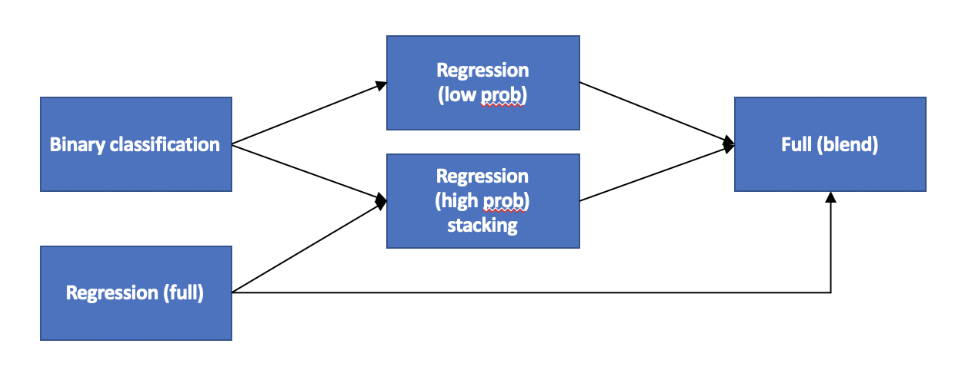

우리 데이터의 특징은 target에 아웃라이어의 수가 많다는 것입니다.
그러므로 이들을 구분해서 따로 학습해주는 작업이 필요합니다.

Binary classification에서 아웃라이어인지 아웃라이어가 아닌지 예측하는 모델을 만듭니다. 이 모델로 일단 아웃라이어인지 아닌지 예측 분류합니다.

Regression(low prob) 이들 중 아웃라이어가 아니라고 예측한 데이터 중 실제 아웃라이어가 아닌 데이터와 아웃라이어 일부를 이용해 회귀 예측 모델을 만듭니다.

Regression(full) 전체 데이터를 LGBM으로 학습시킵니다.

Regression(High prob) Binary classification에서 아웃라이어라고 예측한 데이터 중 실제 아웃라이어인 데이터와 아웃라이어가 아닌 일부 데이터를 이용해 회귀예측모델을 만듭니다.

Full(blend) 세 Regression model에서 구한 예측값을 피쳐로 회귀예측 모델을 만들어 최종 target값을 구합니다.

# Lob Prob Model 작업

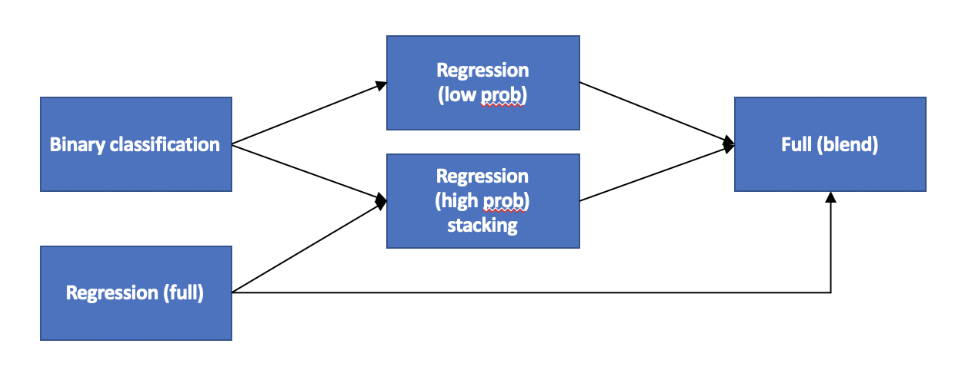

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1

/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1


In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=a7d814c5b926e84ca64bd9f36800299dcc486f3d7d69e4ac6f0be691ba64f82c
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
# !git clone --recursive https://github.com/Microsoft/LightGBM

#출처: https://somjang.tistory.com/entry/Ensemble-Colab에서-LightGBM-사용하기 [솜씨좋은장씨]

In [ ]:
# %cd/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1/LightGBM

In [ ]:
# !mkdir build
# !cmake -DUSE_GPU=1
# !make -j$(nproc)
# !sudo apt-get -y install python-pip
# !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
# %cd/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1/LightGBM/python-package/
# !sudo python setup.py install --precompile


## module을 불러옵니다.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import pickle

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, log_loss

from sklearn.metrics import mean_squared_error
from math import sqrt

import time
import gc
import warnings
warnings.filterwarnings('ignore')

데이터 양을 줄이면서 데이터를 가져옵니다.

In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Load data

In [ ]:
train = reduce_mem_usage(pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/train_features_generated.csv", index_col=0))
test = reduce_mem_usage(pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/test_features_generated.csv"))

Mem. usage decreased to 100.71 Mb (74.7% reduction)
Mem. usage decreased to 60.72 Mb (74.9% reduction)


아웃라이어 여부를 분류하는 모델로 계산한 데이터를 가져옵니다.

In [ ]:
with open('/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1/predicted_labels_train.pkl','rb') as f:
  train_labels = pickle.load(f)

with open('/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1/predicted_labels_test.pkl','rb') as f:
  test_labels = pickle.load(f)


with open('/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1/prob_labels_train.pkl', 'rb') as f:
  train_prob = pickle.load(f)

with open('/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1/prob_labels_test.pkl', 'rb') as f:
  test_prob = pickle.load(f)

In [ ]:
train['outlier_prob'] = train_prob
train['outlier_pred'] = train_labels
test['outlier_prob'] = test_prob
test['outlier_pred'] = test_labels

train, test 데이터를 확인합니다.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 259 entries, card_id to outlier_pred
dtypes: float16(194), float32(14), float64(1), int16(15), int64(1), int8(33), object(1)
memory usage: 103.8+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Columns: 258 entries, Unnamed: 0 to outlier_pred
dtypes: float16(195), float32(14), float64(1), int16(12), int32(1), int64(1), int8(33), object(1)
memory usage: 62.6+ MB


예측 모델 학습을 위해 'card_id'와 'target' 칼럼을 분리해줍니다.

In [ ]:
train_card_ids = train['card_id']
train_target = train['target']
test_card_ids = test['card_id']
test.drop(columns=['card_id'], axis=1, inplace=True)

In [ ]:
train.outlier_pred.value_counts()

0    189666
1     12251
Name: outlier_pred, dtype: int64

## Low Prob Model 학습 전 데이터 전처리

outliers가 아니라고 예측되는 데이터를 low_prob_data로 분리합니다.

In [ ]:
low_prob_data = train[train['outlier_pred'] == 0]
low_prob_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189666 entries, 0 to 201916
Columns: 259 entries, card_id to outlier_pred
dtypes: float16(194), float32(14), float64(1), int16(15), int64(1), int8(33), object(1)
memory usage: 97.5+ MB


outliers가 아니라고 예측되는 데이터 중에서 실제로 아웃라이어인 데이터를 rare_outliers로 분리합니다.

In [ ]:
rare_outliers = low_prob_data[low_prob_data['rare_datapoints']==1]
rare_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996 entries, 64 to 201519
Columns: 259 entries, card_id to outlier_pred
dtypes: float16(194), float32(14), float64(1), int16(15), int64(1), int8(33), object(1)
memory usage: 524.3+ KB


outliers가 아니라고 예측되는 데이터중 실제로 아웃라이어가 아닌 데이터를 low_prob_data로 분리합니다.

In [ ]:
low_prob_data = low_prob_data[low_prob_data['rare_datapoints'] == 0]
low_prob_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188670 entries, 0 to 201916
Columns: 259 entries, card_id to outlier_pred
dtypes: float16(194), float32(14), float64(1), int16(15), int64(1), int8(33), object(1)
memory usage: 97.0+ MB


In [ ]:
rare_outliers = rare_outliers.sample(10)
low_prob_data = low_prob_data.append(rare_outliers, ignore_index=True)

In [ ]:
low_prob_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188680 entries, 0 to 188679
Columns: 259 entries, card_id to outlier_pred
dtypes: float16(194), float32(14), float64(1), int16(15), int64(1), int8(33), object(1)
memory usage: 95.5+ MB


In [ ]:
low_prob_data['target'].value_counts()

 0.000000    1367
 1.000000     117
-1.000000      77
-0.584961      52
-1.005859      50
             ... 
 0.022598       1
-7.160156       1
-0.052429       1
 0.029205       1
 0.005840       1
Name: target, Length: 19210, dtype: int64

예측에 필요한 데이터들과 예측에 필요없는 데이터들을 분리해줍니다.

In [ ]:
y_low_prob = low_prob_data['target']
low_prob_caard_ids = low_prob_data['card_id']
low_prob_data.drop(columns=['card_id', 'target', 'rare_datapoints', 'outlier_pred', 'outlier_prob'], axis=1, inplace=True)

In [ ]:
train.drop(columns=['card_id', 'target', 'rare_datapoints', 'outlier_pred', 'outlier_prob'], axis=1, inplace=True)
test.drop(columns=['outlier_pred', 'outlier_prob'], axis=1, inplace=True)

In [ ]:
low_prob_data.reset_index(drop=True, inplace=True)

## LGBM MODEL Best Hyperparameter tuning


입력된 하이퍼파라미터로 KFold 해서 데이터를 평가하는 함수를 만듭니다.

In [ ]:
def LGB_CV(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1,
          n_estimators,
          colsample_bytree,
          subsample,
          reg_alpha,
          top_rate,
          min_split_gain,
          min_child_weight 
         ):
    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(low_prob_data.shape[0])

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(low_prob_data, y_low_prob)):
      print("fold n°{}".format(fold_))
      trn_data = lgb.Dataset(low_prob_data.iloc[trn_idx],
                              label=y_low_prob.iloc[trn_idx],
                              )
      val_data = lgb.Dataset(low_prob_data.iloc[val_idx],
                              label=y_low_prob.iloc[val_idx],
                              )
      params ={
                'n_estimators':int(n_estimators),
                'num_leaves': int(num_leaves),
                'min_data_in_leaf': int(min_data_in_leaf), 
                'objective':'regression',
                'max_depth': int(max_depth),
                'learning_rate': 0.01,
                "boosting": "gbdt",
                "subsample": subsample,
                "min_child_weight": min_child_weight,
                "min_split_gain": min_split_gain,
                "reg_alpha": reg_alpha,
                "top_rate": top_rate,
                "feature_fraction": feature_fraction,
                "bagging_freq": 1,
                "bagging_fraction": bagging_fraction,
                "colsample_bytree": colsample_bytree,
                "metric": 'rmse',
                "lambda_l1": lambda_l1,
                "verbosity": -1,
                "seed":int(2**fold_),
                "bagging_seed":int(2**fold_),
                "drop_seed":int(2**fold_),
                'boosting_type': 'gbdt'
              }

      clf = lgb.train(params,
                      trn_data,
                      10000,
                      valid_sets = [trn_data, val_data],
                      verbose_eval=500,
                      early_stopping_rounds = 200,
                      )

      oof[val_idx] = clf.predict(low_prob_data.iloc[val_idx],
                                  num_iteration=clf.best_iteration)

      del clf, trn_idx, val_idx
      gc.collect()
        
    return -mean_squared_error(oof, y_low_prob)**0.5

적당한 하이퍼파라미터 범위를 지정해줍니다.

In [ ]:
LGB_BO = BayesianOptimization(LGB_CV, {
    'max_depth': (4, 10),
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'feature_fraction': (0.7, 1.0),
    'n_estimators' : (10, 1000),
    'bagging_fraction': (0.7, 1.0),
    'lambda_l1': (0, 6),
    'top_rate': (0, 1),
    'subsample': (0, 1),
    'colsample_bytree': (0, 1),
    'reg_alpha': (0, 1),
    'min_split_gain': (1,50),
    'min_child_weight': (1, 150)
    })

BayesianOptimization으로 적당한 하이퍼 파라미터를 구합니다.

그리고 코드를 실행하는데 걸린시간도 측정해봅니다.

In [ ]:
start_time = time.time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)
print("Time taken: {} minutes".format(time.time()-start_time))

print('-'*130)
print('Final Results')
print('Maximum  value: %f' % LGB_BO.max['target'])
print('Best  parameters: ', LGB_BO.max['params'])

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | max_depth | min_ch... | min_da... | min_sp... | n_esti... | num_le... | reg_alpha | subsample | top_rate  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.60768	valid_1's rmse: 1.63569
Early stopping, best iteration is:
[652]	training's rmse: 1.60694	valid_1's rmse: 1.6352
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.60939	valid_1's rmse: 1.62227
Early stopping, best iteration is:
[679]	training's rmse: 1.60834	valid_1's rmse: 1.62179
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.60135	valid_1's rmse: 1.65587
Early stopping, best iteration is:
[625]	training's rmse: 1.60045	valid_1's 

Best Training 하이퍼파라미터로 학습시킵니다.
int만 입력값으로 받는 max_depth, n_estimators, num_leaves, min_data_in_leaf는 반올림하여 입력합니다.

그리고 kfold로 교차해서 학습, 평가합니다. 
그리고 피쳐별 중요도를 나타내는 데이터프레임도 생성합니다.




Best  parameters:  {'bagging_fraction': 0.7834391588770753, 'colsample_bytree': 0.26732131204631693, 'feature_fraction': 0.8788924282173596, 'lambda_l1': 4.370060000291447, 'max_depth': 9.021628187349243, 'min_child_weight': 147.79083234989923, 'min_data_in_leaf': 100.35502544449928, 'min_split_gain': 4.7809759132874685, 'n_estimators': 930.5271986951851, 'num_leaves': 127.01009981646217, 'reg_alpha': 0.6345399624202346, 'subsample': 0.9346253975371165, 'top_rate': 0.22358506207745565}


In [ ]:
params = {
          'bagging_fraction': 0.7834391588770753,
          'colsample_bytree': 0.26732131204631693,
          'feature_fraction': 0.8788924282173596,
          'lambda_l1': 4.370060000291447,
          'max_depth': 9,
          'min_child_weight': 147.79083234989923,
          'min_data_in_leaf': 100,
          'min_split_gain': 4.7809759132874685,
          'n_estimators': 931,
          'num_leaves': 1277,
          'reg_alpha': 0.6345399624202346,
          'subsample': 0.9346253975371165,
          'top_rate': 0.22358506207745565,
          'metric': 'rmse'
          }

feature_importance_df = pd.DataFrame()
columns = low_prob_data.columns

folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=15)
oof = np.zeros(low_prob_data.shape[0])
train_preds = np.zeros(train.shape[0])
test_predictions_low_prob = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(low_prob_data, y_low_prob)):
  print("fold n°{}".format(fold_))
  trn_data = lgb.Dataset(low_prob_data.iloc[trn_idx],
                          label=y_low_prob.iloc[trn_idx],
                          )
  val_data = lgb.Dataset(low_prob_data.iloc[val_idx],
                          label=y_low_prob.iloc[val_idx],
                          )

  clf = lgb.train(params,
                  trn_data,
                  10000,
                  valid_sets = [trn_data, val_data],
                  verbose_eval=500,
                  early_stopping_rounds = 200,
                  )

  oof[val_idx] = clf.predict(low_prob_data.iloc[val_idx],
                              num_iteration=clf.best_iteration)
  test_predictions_low_prob += clf.predict(test, num_iteration=clf.best_iteration) / (5*2)
  train_preds += clf.predict(train, num_iteration=clf.best_iteration) / (5*2)

  fold_importance_df = pd.DataFrame()
  fold_importance_df["feature"] = columns
  fold_importance_df["importance"] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
  fold_importance_df["fold"] = fold_ + 1
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

cv_rmse = sqrt(mean_squared_error(y_low_prob, oof))
print('*'*100)
print("CV RMSE: {:2.5f}".format(cv_rmse))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[66]	training's rmse: 1.51207	valid_1's rmse: 1.63095
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[55]	training's rmse: 1.52355	valid_1's rmse: 1.61925
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[63]	training's rmse: 1.5046	valid_1's rmse: 1.651
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[78]	training's rmse: 1.50918	valid_1's rmse: 1.59578
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[62]	training's rmse: 1.51577	valid_1's rmse: 1.61257
fold n°5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 1.51174	valid_1's rmse: 1.61896
fold n°6
Training until validation sc

위의 베스트 하이퍼 파라미터로 구한 예측 모델 결과들의 RMSE를 구합니다.

In [ ]:
cv_rmse = sqrt(mean_squared_error(train_preds, train_target))
print("Entire Train data RMSE: {:2.5f}".format(cv_rmse))

Entire Train data RMSE: 3.80264


## Evaluate the models on entire train data

In [ ]:
low_prob_train = pd.DataFrame()
low_prob_train['card_id'] = train_card_ids
low_prob_train['low_prob_score'] = train_preds

In [ ]:
low_prob_test = pd.DataFrame()
low_prob_test['card_id'] = test_card_ids
low_prob_test['low_prob_score'] = test_predictions_low_prob

In [ ]:
cd/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1

/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1


In [ ]:
with open('low_prob_test_predictions.pkl', 'wb') as f:
  pickle.dump(low_prob_test, f)

with open('low_prob_train_predictions.pkl', 'wb') as f:
  pickle.dump(low_prob_train, f)

In [ ]:
low_prob_train.head()

,card_id,low_prob_score
0,C_ID_92a2005557,-0.253730
1,C_ID_3d0044924f,-0.269649
2,C_ID_d639edf6cd,0.331328
3,C_ID_186d6a6901,-0.041010
4,C_ID_cdbd2c0db2,-0.589267


In [ ]:
low_prob_test.head()

,card_id,low_prob_score
0,C_ID_0ab67a22ab,1.289944
1,C_ID_130fd0cbdd,1.586039
2,C_ID_b709037bc5,0.912936
3,C_ID_d27d835a9f,1.673100
4,C_ID_2b5e3df5c2,1.439358


# Full Regression Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=c01e23bde45d76a54bc73b18395b58797309823ca26e7744916fec56773453cf
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import StackingRegressor
from bayes_opt import BayesianOptimization
from sklearn.linear_model import BayesianRidge

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from math import sqrt

import joblib
import pickle

from tqdm import tqdm_notebook as tqdm
import time
import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Data Load

In [ ]:
train = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/KDT/모델링 프로젝트/data/train_features_generated.csv', index_col=0))
test = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/KDT/모델링 프로젝트/data/test_features_generated.csv', index_col=0))

Mem. usage decreased to 100.71 Mb (74.7% reduction)
Mem. usage decreased to 61.19 Mb (74.7% reduction)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 257 entries, card_id to rare_datapoints
dtypes: float16(194), float32(14), int16(15), int8(33), object(1)
memory usage: 100.7+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Columns: 255 entries, card_id to merchant_active_months_lag12_12.0_std
dtypes: float16(195), float32(14), int16(12), int8(33), object(1)
memory usage: 61.2+ MB


학습에 필요한 칼럼과 그렇지 않은 칼럼을 나눠줍니다.

In [ ]:
y_train = train['target']
train_card_ids = train['card_id']
train.drop(columns=['card_id', 'target'], inplace=True, axis=1)
X_train = train

In [ ]:
card_ids = test['card_id']
test.drop(columns=['card_id'], inplace=True, axis=1)

In [ ]:
columns = train.columns
columns = columns.drop('rare_datapoints')

## Best Hyper parameter 찾기 작업

입력된 파라미터로 학습후 KFold로 교차 검증하는 함수를 만들고 이를 통해 최적의 파라미터를 찾습니다.

In [ ]:
def LGB_CV_Bagging(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1,
          n_estimators,
          colsample_bytree,
          subsample,
          reg_alpha,
          reg_lambda,
          top_rate,
          other_rate,
          min_split_gain,
          min_child_weight
         ):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(X_train.shape[0])

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[columns], X_train['rare_datapoints'])):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(X_train[columns].iloc[trn_idx],
                               label=y_train.iloc[trn_idx],
                               )
        val_data = lgb.Dataset(X_train[columns].iloc[val_idx],
                               label=y_train.iloc[val_idx],
                               )
    
        param = {
            'task' : 'train',
            'objective' : 'regression',
            'n_estimators':int(n_estimators),
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'regression',
            'max_depth': int(max_depth),
            'learning_rate': 0.01,
            "boosting": "gbdt",
            "subsample": subsample,
            'colsample_bytree': colsample_bytree,
            "min_child_weight": min_child_weight,
            "min_split_gain": min_split_gain,
            "reg_alpha": reg_alpha,
            "reg_lambda" : reg_lambda,
            "top_rate": top_rate,
            'other_rate': other_rate,
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "metric": 'rmse',
            "lambda_l1": lambda_l1,
            "verbosity": -1,
            "stratified" : False
        }
    
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)
        
        oof[val_idx] = clf.predict(X_train[columns].iloc[val_idx],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
        
    return -mean_squared_error(oof, y_train)**0.5

파라미터들의 범위를 지정해줍니다.

In [ ]:
LGB_BO = BayesianOptimization(LGB_CV_Bagging, {
    'max_depth': (4, 10),
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'feature_fraction': (0.7, 0.99),
    'n_estimators' : (10, 750),
    'bagging_fraction': (0.7, 0.99),
    'lambda_l1': (0, 6),
    'top_rate': (0, 1),
    "other_rate" : (0, 1),
    'subsample': (0, 1),
    'colsample_bytree': (0, 1),
    'reg_alpha': (0, 1),
    "reg_lambda" : (0,10),
    'min_split_gain': (1,50),
    'min_child_weight': (1, 150)
    })

In [ ]:
start_time = time.time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=30, acq='ei', xi=0.0)
print("Time taken", time.time()-start_time)
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % LGB_BO.max['target'])
print('Best  parameters: ', LGB_BO.max['params'])

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | max_depth | min_ch... | min_da... | min_sp... | n_esti... | num_le... | other_... | reg_alpha | reg_la... | subsample | top_rate  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.50619	valid_1's rmse: 3.71251
Did not meet early stopping. Best iteration is:
[509]	training's rmse: 3.50406	valid_1's rmse: 3.7126
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5086	valid_1's rmse: 3.68844
Did not meet early stopping. Best iteration is:
[509]	training's rmse: 3.50684	valid_1's rmse: 3.68834
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.50266	valid_1's rmse: 3.71522
Did

1st tuning

Best  parameters:  {'bagging_fraction': 0.8686284977920036, 'feature_fraction': 0.8482092154218599, 'lambda_l1': 4.1639135977176585, 'max_depth': 9.576234490755708, 'min_data_in_leaf': 83.68633283126034, 'n_estimators': 660.3399358967316, 'num_leaves': 90.81288796818258}



2nd tuning
Final Results11600

Maximum  value: -3.700202
Best  parameters:  {'bagging_fraction': 0.9148169692127184, 'colsample_bytree': 0.6298140131171257, 'feature_fraction': 0.8443429059267908, 'lambda_l1': 5.856986534932158, 'max_depth': 9.784578342839247, 'min_child_weight': 87.83424542183701, 'min_data_in_leaf': 91.81371886805323, 'min_split_gain': 18.27574916027187, 'n_estimators': 562.2834742348521, 'num_leaves': 129.74985890479212, 'other_rate': 0.35029742612279446, 'reg_alpha': 0.9803638943393569, 'reg_lambda': 8.145900153921245, 'subsample': 0.4885657717026137, 'top_rate': 0.01689801630741028}

best hyperparameter를 입력해 예측하고 평가해봅니다.

In [ ]:
# Sleep for a few seconds.
import time
time.sleep(2)

# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
cd/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1

/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1


In [ ]:
params = {
          'task': 'train',
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.01,
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "stratified" : False,
          'bagging_fraction': 0.9148169692127184,
          'colsample_bytree': 0.6298140131171257,
          'feature_fraction': 0.8443429059267908,
          'lambda_l1': 5.856986534932158,
          'max_depth': 10,
          'min_child_weight': 87.83424542183701,
          'min_data_in_leaf': 92,
          'min_split_gain': 18.27574916027187,
          'n_estimators': 562,
          'num_leaves': 130,
          'other_rate': 0.35029742612279446,
          'reg_alpha': 0.9803638943393569,
          'reg_lambda': 8.145900153921245,
          'subsample': 0.4885657717026137,
          'top_rate': 0.01689801630741028
          }

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
oof = np.zeros(X_train.shape[0])
test_predictions = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[columns], X_train['rare_datapoints'])):
  print("fold n°{}".format(fold_))
  trn_data = lgb.Dataset(X_train[columns].iloc[trn_idx],
                          label=y_train.iloc[trn_idx],
                          )
  val_data = lgb.Dataset(X_train[columns].iloc[val_idx],
                          label=y_train.iloc[val_idx],
                          )

  clf = lgb.train(params,
                  trn_data,
                  10000,
                  valid_sets = [trn_data, val_data],
                  verbose_eval=500,
                  early_stopping_rounds = 200,
                  )

  oof[val_idx] = clf.predict(X_train[columns].iloc[val_idx],
                              num_iteration=clf.best_iteration)
  
  #save the model for final pipeline
  filename = 'Goss_StratifiedKFold_Model_' + str(fold_+1) + '.pkl'
  with open(filename, 'wb') as f:
    pickle.dump(clf, f)

  #Test predictions  
  test_predictions += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.37494	valid_1's rmse: 3.68233
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.35471	valid_1's rmse: 3.68181
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.37436	valid_1's rmse: 3.69956
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.35479	valid_1's rmse: 3.69937
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.36992	valid_1's rmse: 3.70225
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.34672	valid_1's rmse: 3.70226
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.378	valid_1's rmse: 3.69242
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.35527	valid_1's rmse: 3.69196
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	trai

In [ ]:
cv_rmse = sqrt(mean_squared_error(y_train, oof))
print("CV RMSE: {:2.5f}".format(cv_rmse))

CV RMSE: 3.69974


## Model 학습 후 평가

다시 LGBM으로 모델 학습 후 KFold로 교차 검증합니다.

In [ ]:
feature_importance_df = pd.DataFrame()


folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=5)
oof_2 = np.zeros(X_train.shape[0])
test_predictions_2 = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[columns], y_train.values)):
  print("fold n°{}".format(fold_))
  trn_data = lgb.Dataset(X_train[columns].iloc[trn_idx],
                          label=y_train.iloc[trn_idx],
                          )
  val_data = lgb.Dataset(X_train[columns].iloc[val_idx],
                          label=y_train.iloc[val_idx],
                          )
  params ={
          'task': 'train',
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.01,
          "bagging_freq": 1,
          "bagging_seed": 11,
          "verbosity": -1,
          "stratified" : False,
          'bagging_fraction': 0.9148169692127184,
          'colsample_bytree': 0.6298140131171257,
          'feature_fraction': 0.8443429059267908,
          'lambda_l1': 5.856986534932158,
          'max_depth': 10,
          'min_child_weight': 87.83424542183701,
          'min_data_in_leaf': 92,
          'min_split_gain': 18.27574916027187,
          'n_estimators': 562,
          'num_leaves': 130,
          'other_rate': 0.35029742612279446,
          'reg_alpha': 0.9803638943393569,
          'reg_lambda': 8.145900153921245,
          'subsample': 0.4885657717026137,
          'top_rate': 0.01689801630741028
                }

  clf = lgb.train(params,
                  trn_data,
                  10000,
                  valid_sets = [trn_data, val_data],
                  verbose_eval=500,
                  early_stopping_rounds = 200,
                  )

  oof_2[val_idx] = clf.predict(X_train[columns].iloc[val_idx],
                              num_iteration=clf.best_iteration)

  test_predictions_2 += clf.predict(test, num_iteration=clf.best_iteration) / (5*2)

  fold_importance_df = pd.DataFrame()
  fold_importance_df["feature"] = columns
  fold_importance_df["importance"] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
  fold_importance_df["fold"] = fold_ + 1
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.39917	valid_1's rmse: 3.59968
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.3801	valid_1's rmse: 3.59947
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.35705	valid_1's rmse: 3.73065
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.33464	valid_1's rmse: 3.73073
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.38028	valid_1's rmse: 3.71081
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.35876	valid_1's rmse: 3.71054
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.37972	valid_1's rmse: 3.64369
Did not meet early stopping. Best iteration is:
[562]	training's rmse: 3.35883	valid_1's rmse: 3.64308
fold n°4
Training until validation scores don't improve for 200 rounds.
[500]	tra

In [ ]:
cv_rmse = sqrt(mean_squared_error(y_train, oof_2))
print("CV RMSE: {:2.5f}".format(cv_rmse))

CV RMSE: 3.70033


In [ ]:
train_preds = pd.DataFrame()
test_preds = pd.DataFrame()

train_preds['card_id'] = train_card_ids
train_preds['full_regression_prediction'] = oof_2
test_preds['card_id'] = card_ids
test_preds['full_regression_prediction'] = test_predictions_2

In [ ]:
with open('train_predictions_full_regression.pkl', 'wb') as f:
  pickle.dump(train_preds,f)

with open('test_predictions_full_regression.pkl', 'wb') as f:
  pickle.dump(test_preds,f)

In [ ]:
train_preds

,card_id,full_regression_prediction
0,C_ID_92a2005557,-0.221721
1,C_ID_3d0044924f,-0.330804
2,C_ID_d639edf6cd,0.081999
3,C_ID_186d6a6901,-0.192981
4,C_ID_cdbd2c0db2,-0.334109
...,...,...
201912,C_ID_963962de2c,0.205108
201913,C_ID_1314773c0b,-0.280603
201914,C_ID_7666735b3d,0.007375
201915,C_ID_73f5a0efd0,-1.473949


## Feature Importance in Full Regression

위의 LGBM에서 예측한 값에서 feature importance를 구해 차례대로 나열합니다.
이 데이터는 후에 요긴하게 쓰일 예정이라서 저장까지 할 것입니다.

In [ ]:
def display_importances(feature_importance_df_, num_top_features):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:num_top_features].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(25, 25))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)', fontsize = 25)
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')
    return cols

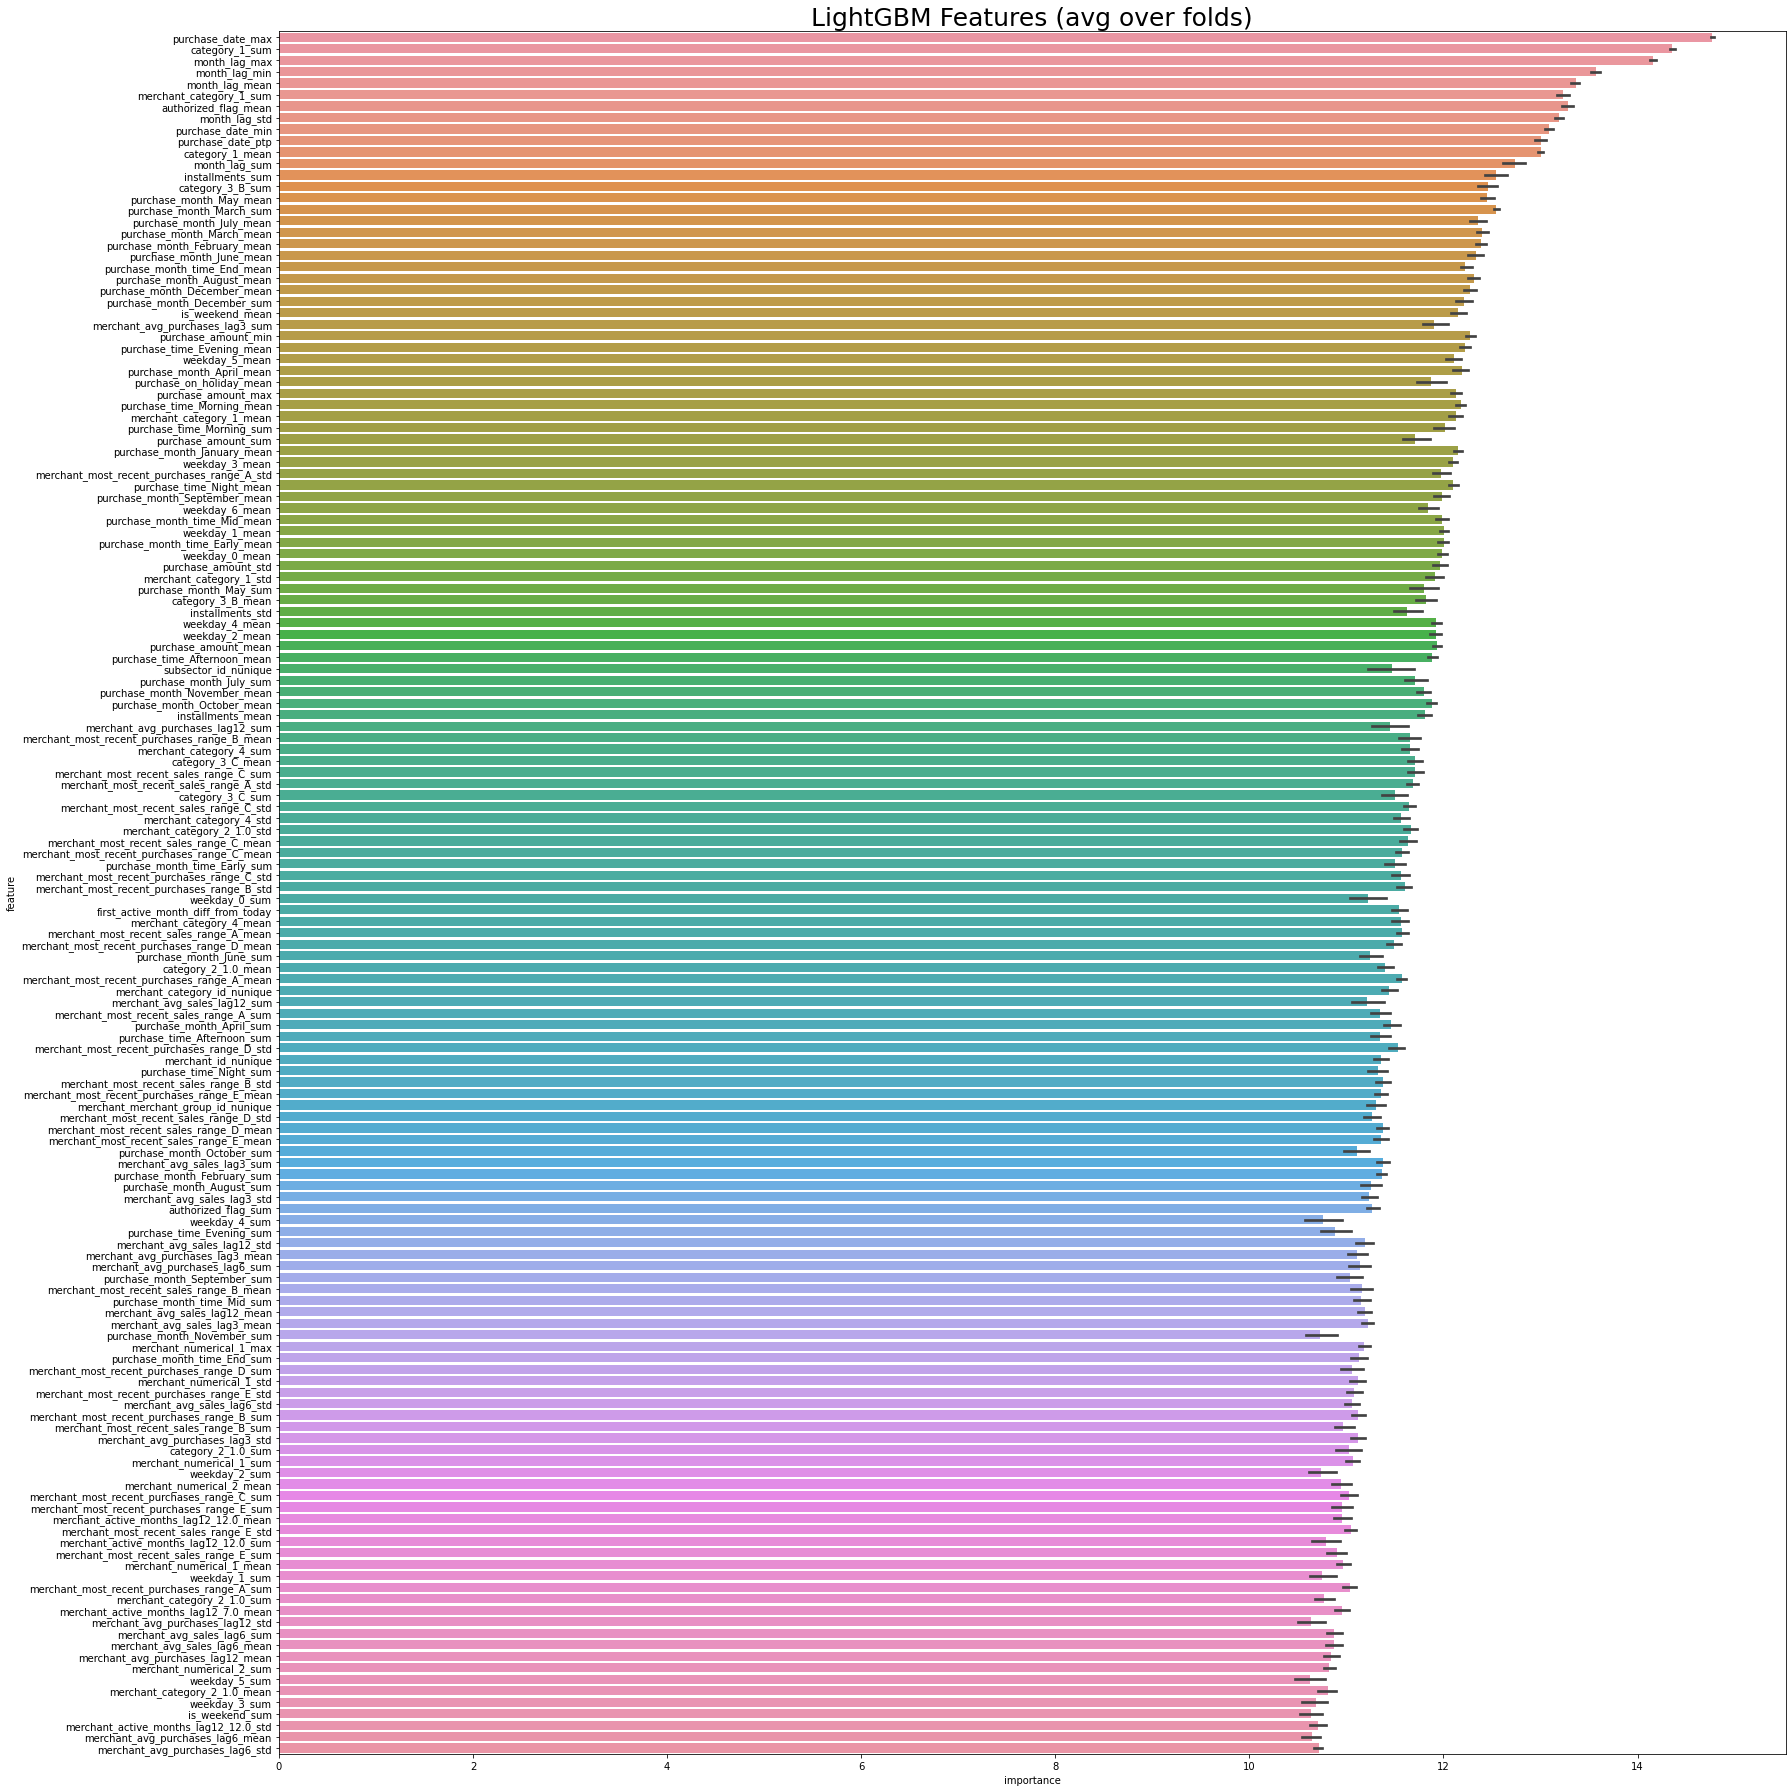

In [ ]:
top_150_features = display_importances(feature_importance_df, 150)
top_200_features = display_importances(feature_importance_df, 200)

In [ ]:
import pickle

with open('top_150_features.pkl', 'wb') as f:
  pickle.dump(top_150_features,f)

# HighProb Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1

/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1


In [ ]:
pip install bayesian-optimization

module을 불러옵니다.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import pickle

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, log_loss

from sklearn.metrics import mean_squared_error
from math import sqrt

import time
import gc
import warnings
warnings.filterwarnings('ignore')

데이터 양을 줄이면서 데이터를 가져옵니다.

In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Load data

In [ ]:
train = reduce_mem_usage(pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/train_features_generated.csv", index_col=0))
test = reduce_mem_usage(pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/test_features_generated.csv"))

Mem. usage decreased to 100.71 Mb (74.7% reduction)
Mem. usage decreased to 60.72 Mb (74.9% reduction)


아웃라이어 여부를 분류하는 모델로 계산한 데이터를 가져옵니다.

In [ ]:
with open('/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1/predicted_labels_train.pkl','rb') as f:
  train_labels = pickle.load(f)

with open('/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1/predicted_labels_test.pkl','rb') as f:
  test_labels = pickle.load(f)


with open('/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1/prob_labels_train.pkl', 'rb') as f:
  train_prob = pickle.load(f)

with open('/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1/prob_labels_test.pkl', 'rb') as f:
  test_prob = pickle.load(f)

In [ ]:
train['outlier_prob'] = train_prob
train['outlier_pred'] = train_labels
test['outlier_prob'] = test_prob
test['outlier_pred'] = test_labels

train, test 데이터를 확인합니다.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 259 entries, card_id to outlier_pred
dtypes: float16(194), float32(14), float64(1), int16(15), int64(1), int8(33), object(1)
memory usage: 103.8+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Columns: 258 entries, Unnamed: 0 to outlier_pred
dtypes: float16(195), float32(14), float64(1), int16(12), int32(1), int64(1), int8(33), object(1)
memory usage: 62.6+ MB


In [ ]:
#Load the full regression predictions

with open('train_predictions_full_regression.pkl', 'rb') as f:
  full_regression_train_preds = pickle.load(f)

with open('test_predictions_full_regression.pkl', 'rb') as f:
  full_regression_test_preds = pickle.load(f)

In [ ]:
train = train.merge(full_regression_train_preds, on='card_id', how='left')
test = test.merge(full_regression_test_preds, on='card_id', how='left')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 260 entries, card_id to full_regression_prediction
dtypes: float16(194), float32(14), float64(2), int16(15), int64(1), int8(33), object(1)
memory usage: 105.3+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Columns: 259 entries, Unnamed: 0 to full_regression_prediction
dtypes: float16(195), float32(14), float64(2), int16(12), int32(1), int64(1), int8(33), object(1)
memory usage: 64.5+ MB


예측 모델 학습을 위해 'card_id'와 'target' 칼럼을 분리해줍니다.

In [ ]:
train_card_ids = train['card_id']
train_target = train['target']
test_card_ids = test['card_id']
test.drop(columns=['card_id'], axis=1, inplace=True)

## High Prob Model

stacking model

아웃라이어라고 예측한 모델을 high_prob_data로 분리합니다.

In [ ]:
high_prob_data = train[train['outlier_pred'] == 1]
high_prob_data.info

<bound method DataFrame.info of                 card_id    target  ...  outlier_pred  full_regression_prediction
35      C_ID_022b48f3ac  1.233398  ...             1                   -2.511480
41      C_ID_69e95a3ec9 -0.247437  ...             1                   -2.966735
67      C_ID_8e6c22b8b8 -1.415039  ...             1                   -5.838291
96      C_ID_24b7e16c4f -2.789062  ...             1                   -1.486886
113     C_ID_cc6bf68bd6 -2.615234  ...             1                   -0.287480
...                 ...       ...  ...           ...                         ...
201799  C_ID_6aed07d9d0  2.066406  ...             1                   -1.038458
201810  C_ID_39a9e244f4 -3.181641  ...             1                   -3.514519
201811  C_ID_8b693324b8 -0.048523  ...             1                   -2.281114
201858  C_ID_32c187500f  0.038971  ...             1                   -4.747760
201877  C_ID_cef26bf683  1.687500  ...             1                   -3.770

high_prob_data 중 아웃라이어가 아닌 데이터는 rare_outliers로 변수처리합니다.

In [ ]:
rare_outliers = high_prob_data[high_prob_data['rare_datapoints'] == 0]
rare_outliers.info

<bound method DataFrame.info of                 card_id    target  ...  outlier_pred  full_regression_prediction
35      C_ID_022b48f3ac  1.233398  ...             1                   -2.511480
41      C_ID_69e95a3ec9 -0.247437  ...             1                   -2.966735
67      C_ID_8e6c22b8b8 -1.415039  ...             1                   -5.838291
96      C_ID_24b7e16c4f -2.789062  ...             1                   -1.486886
113     C_ID_cc6bf68bd6 -2.615234  ...             1                   -0.287480
...                 ...       ...  ...           ...                         ...
201799  C_ID_6aed07d9d0  2.066406  ...             1                   -1.038458
201810  C_ID_39a9e244f4 -3.181641  ...             1                   -3.514519
201811  C_ID_8b693324b8 -0.048523  ...             1                   -2.281114
201858  C_ID_32c187500f  0.038971  ...             1                   -4.747760
201877  C_ID_cef26bf683  1.687500  ...             1                   -3.770

high_prob_data에서 아웃라이어인 데이터만 변수처리합니다.

In [ ]:
high_prob_data = high_prob_data[high_prob_data['rare_datapoints'] == 1]
rare_outliers = rare_outliers.sample(411)

rare_outliers 중 일부를 high_prob_data에 포함시킵니다.

In [ ]:
high_prob_data = high_prob_data.append(rare_outliers, ignore_index=True)
high_prob_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622 entries, 0 to 1621
Columns: 260 entries, card_id to full_regression_prediction
dtypes: float16(194), float32(14), float64(2), int16(15), int64(1), int8(33), object(1)
memory usage: 853.9+ KB


Full regression model에서 구한 top_150_feature를 load합니다.

조금씩 줄여가며 모델에 사용하겠습니다. 점수가 제일 높게 나오는 숫자로 가겠습니다.

In [ ]:
#Load the top 150 features
#Start with top 50

with open('top_150_features.pkl', 'rb') as f:
  top_features = pickle.load(f)

top_features = list(top_features[:20])

세 데이터를 top_feature에 추가합니다.

In [ ]:
top_features.append('full_regression_prediction')
top_features.append('outlier_prob')
top_features.append('outlier_pred')

target 데이터와 card_id data, 그외에 학습에 필요한 피쳐들을 구분합니다.

In [ ]:
y_high_prob = high_prob_data['target']
high_prob_card_ids = high_prob_data['card_id']
high_prob_data.drop(columns=['card_id', 'target', 'rare_datapoints'], axis=1, inplace=True)

top_feature 들만 뽑아낸다.

In [ ]:
high_prob_data = high_prob_data[top_features]
train = train[top_features]
test = test[top_features]

LGBM Regressor와 BayesianRidge 중 더 좋은 성능을 내는 모델을 고른다.

KFold로 교차 검증한다.

In [ ]:
folds_stack = KFold(n_splits=5, shuffle=True, random_state=4590)
oof_high_pred = np.zeros(high_prob_data.shape[0])
train_pred = np.zeros(train.shape[0])
pred_high_prob = np.zeros(test.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(high_prob_data,y_high_prob)):
    print("fold {}".format(fold_))
    trn_data, trn_y = high_prob_data.iloc[trn_idx], y_high_prob.iloc[trn_idx]
    val_data, val_y = high_prob_data.iloc[val_idx], y_high_prob.iloc[val_idx]
    
    #clf_3 = lgb.LGBMRegressor()
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_high_pred[val_idx] = clf_3.predict(val_data)
    train_pred += clf_3.predict(train) / 5
    pred_high_prob += clf_3.predict(test) / 5
    
np.sqrt(mean_squared_error(y_high_prob.values, oof_high_pred))

fold 0
fold 1
fold 2
fold 3
fold 4


14.102097228796003

In [ ]:
cv_rmse = sqrt(mean_squared_error(y_high_prob.values, oof_high_pred))
print("CV RMSE: {:2.5f}".format(cv_rmse))

CV RMSE: 14.10210


In [ ]:
cv_rmse = sqrt(mean_squared_error(train_pred, train_target))
print("Entire Train data RMSE: {:2.5f}".format(cv_rmse))

Entire Train data RMSE: 19.64357


예측값의 최대 최소값을 확인한다.

In [ ]:
print(max(train_pred))
print(min(train_pred))

21.30718266334
-87.64091628672526


In [ ]:
print(max(pred_high_prob))
print(min(pred_high_prob))

13.684064522026205
-56.23273217866572


## Evaluate the models on entire train data

card_id 칼럼과 target column을 구성한다.

In [ ]:
high_prob_train = pd.DataFrame()
high_prob_train['card_id'] = train_card_ids
high_prob_train['high_prob_score'] = train_pred
high_prob_train.head()

,card_id,high_prob_score
0,C_ID_92a2005557,-17.010247
1,C_ID_3d0044924f,-21.540437
2,C_ID_d639edf6cd,-19.110552
3,C_ID_186d6a6901,-19.271528
4,C_ID_cdbd2c0db2,-19.825769


In [ ]:
high_prob_test = pd.DataFrame()
high_prob_test['card_id'] = test_card_ids
high_prob_test['high_prob_score'] = pred_high_prob

train 데이터에서 target의 최저값이 -33.218750 이었기 때문에 그보다 작은 것들은 이것으로 치환한다.

In [ ]:
high_prob_train['high_prob_score'] = high_prob_train['high_prob_score'].apply(lambda x: -33.218750 if x < -33.218750 else x)
high_prob_test['high_prob_score'] = high_prob_test['high_prob_score'].apply(lambda x: -33.218750 if x < -33.218750 else x)

치환 후의 RMSE를 확인해봅시다.

In [ ]:
cv_rmse = sqrt(mean_squared_error(high_prob_train['high_prob_score'], train_target))
print("CV RMSE: {:2.5f}".format(cv_rmse))

CV RMSE: 19.64127


In [ ]:
with open('high_prob_train_predictions.pkl', 'wb') as f:
  pickle.dump(high_prob_train, f)

with open('high_prob_test_predictions.pkl', 'wb') as f:
  pickle.dump(high_prob_test, f)

# Final Blending

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1

/content/drive/MyDrive/KDT/모델링 프로젝트/data/data_1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import pickle

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, log_loss

from sklearn.metrics import mean_squared_error
from math import sqrt

import time
import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Data Load

In [ ]:
train = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/KDT/모델링 프로젝트/data/train_features_generated.csv', index_col=0))
test = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/KDT/모델링 프로젝트/data/test_features_generated.csv', index_col=0))

Mem. usage decreased to 100.71 Mb (74.7% reduction)
Mem. usage decreased to 61.19 Mb (74.7% reduction)


위의 예측 모델들로 만든 예측값들을 불러옵니다.

In [ ]:
with open('low_prob_test_predictions.pkl', 'rb') as f:
  test_low_pred = pickle.load(f)

with open('low_prob_train_predictions.pkl', 'rb') as f:
  train_low_pred = pickle.load(f)

with open('high_prob_train_predictions.pkl', 'rb') as f:
  train_high_pred = pickle.load(f)

with open('high_prob_test_predictions.pkl', 'rb') as f:
  test_high_pred = pickle.load(f)

#Load the full regression predictions

with open('train_predictions_full_regression.pkl', 'rb') as f:
  full_regression_train_preds = pickle.load(f)

with open('test_predictions_full_regression.pkl', 'rb') as f:
  full_regression_test_preds = pickle.load(f)

불러온 모든 파일들과 병합해줍니다.

In [ ]:
train = train.merge(train_low_pred, on = 'card_id', how='left')
train = train.merge(train_high_pred, on = 'card_id', how='left')
train = train.merge(full_regression_train_preds, on = 'card_id', how='left')

test = test.merge(test_low_pred, on = 'card_id', how='left')
test = test.merge(test_high_pred, on = 'card_id', how='left')
test = test.merge(full_regression_test_preds, on = 'card_id', how='left')

card_id 칼럼과 target 칼럼을 분리해줍니다.

In [ ]:
train_target = train['target']
test_card_id = test['card_id']

블렌딩에 필요한 피쳐들만 추출합니다.
블렌딩에는 

In [ ]:
columns = ['low_prob_score', 'high_prob_score', 'full_regression_prediction']
train = train[columns]
test = test[columns]

## Full Blend Model

BayesianRegression model 으로 모델링 시도합니다.

두번째는 RandomforestRegressor: 3.79391600433

세번째 Linear Regression: 3.68191541424833

네번째 sgdr : 3.96

SGDR Parameter Tuning

In [ ]:
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
params = {'alpha': alpha}

model=SGDRegressor()
random_search = RandomizedSearchCV(model, params, scoring = 'neg_root_mean_squared_error', cv = 5)
random_search.fit(train, train_target)
random_search.best_params_

{'alpha': 0.01}

KFold stacking으로 모델의 성능을 검증합니다.

In [ ]:
folds_stack = KFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train,train_target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train.iloc[trn_idx], train_target.iloc[trn_idx]
    val_data, val_y = train.iloc[val_idx], train_target.iloc[val_idx]
    
    clf_3 = SGDRegressor(alpha=0.01)
    clf_3.fit(trn_data, trn_y)
    
    oof[val_idx] = clf_3.predict(val_data)
    test_pred += clf_3.predict(test) / 5
    
print("CV RMSE:", np.sqrt(mean_squared_error(train_target.values, oof)))

fold 0
fold 1
fold 2
fold 3
fold 4
CV RMSE: 3.7067502698713315


## Kaggle Submission

In [ ]:
kaggle_submission = pd.DataFrame()
kaggle_submission['card_id'] = test_card_id
kaggle_submission['target'] = test_pred

In [ ]:
kaggle_submission

,card_id,target
0,C_ID_0ab67a22ab,-0.000377
1,C_ID_130fd0cbdd,1.608491
2,C_ID_b709037bc5,0.878094
3,C_ID_d27d835a9f,1.335829
4,C_ID_2b5e3df5c2,0.771894
...,...,...
123618,C_ID_7a239d2eda,2.700777
123619,C_ID_75ace375ae,1.259958
123620,C_ID_21d56d950c,2.403817
123621,C_ID_6c46fc5a9d,-0.871239


In [ ]:
kaggle_submission.to_csv('final_blended_model_sgdr.csv', index=0)

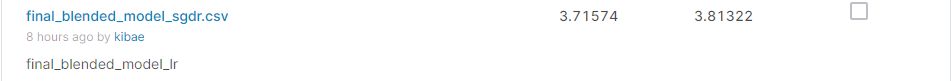

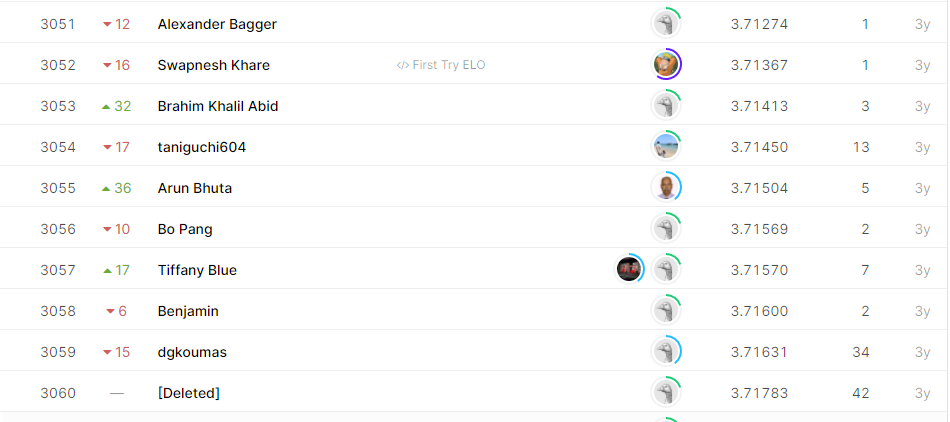